In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is the second attempt to read in track information and use it to predict the KDE used as input to PvFinder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_C.py uses poca_z, poca_x, poca_y, major_axis_x, major_axis_y, and major_axis_z as the six track parameters (for the moment)


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Fri Aug 27 17:56:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   33C    P8    23W / 250W |      4MiB / 12066MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 150

# Name is the output file name


##  201027 -- about to go to bed, so try 2500 epochs with lr = 1e55
##  previous iteration had l4 = 3e-5 and cost dropped almost linearly
##  for 100 epochs -- final training costs ~ 2.02, validation cost ~ 2.01

## for iter 4, try 10 epochs with lr = 3e-6
## usually have a big jump down at epoch 0; want to try a
## small number of epochs per iteration and see what happens (iter4: 10 epochs gave
## traiing cost dropping from 1.54 to 1.50 immediately, then dropping very slowly)
folder = 'baileyds150ep_DDplus_iter2'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'saved/' + folder
output = Path(folder)


# Size of batches
batch_size = 16 ## was 64
# How fast to learn
learning_rate = 1e-5

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_B import collect_t2kde_data
## collectdata_kde_C should use the new poca KDE rather than the original kernel KDE
from model.collectdata_kde_Ellipsoids import collect_t2kde_data


# From model/loss.py
##from loss import Loss
## kde_loss_D includes botha ratio term and a chisq term, 98% ave_chisq
## kde_loss_E adds a chi^4 term to the kde_loss_D return value
## this is intended to emphasize the importance of values significantly different than zero
from model.kde_loss_Ba import Loss

##  TracksToKDE_Ellipsoids_SevenLayerCake has 7 hidden layers producing the 4000-bin KDE historgram
##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as Model


from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)
# my entry 
from functions.utils import get_param_state
param_states = []

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = "cuda:0"#select_gpu(0)
##device = "cpu"

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [9]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [10]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-5, debug=False)
loss = Loss(epsilon=3e-5)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [11]:
model = model.to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]

model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()
##print("updated model_dict = ",model_dict)

## print(" \n","  for pretrained_dict")
## index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
##print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)

# ## finished at training cost = 1.46, validation cost = 1.50
d_folder = 'baileyds100ep_DDplus_fromstart'
d_name = d_folder
suffix = 'final'
dict_name = 'saved/' + d_folder + '/' + d_name + '_'+ suffix + '.pyt'
print('dict_name = ',dict_name)
pretrained_dict = torch.load(dict_name)

# print(" ")
# print("  for pretrained_dict")
# index = 0
# for k,v in pretrained_dict.items():
#     print("index, k =  ",index,"  ",k)
#     index = index+1
 

# ##print("model_dict instantiated")
# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# print("pretrained_dict iterated")
# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# ##
# #   when starting from a model with a fully connected last layer rather than a convolutional layer
# # 3. load the new state dict
# #   need to use strict=False as the two models state model attributes do not agree exactly
# #   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)

#mine
param_states.append(get_param_state(model))


output =  saved/baileyds150ep_DDplus_iter2
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12new.weight
index, k =   23    layer12new.bias
index, k =   24    conv1.weight
index, k =   25    conv1.bias
index, k =   26    conv2.weight
index, k =   27    conv2.bias
index, k =   28    fc1.weight
index, k =   29   

In [14]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [15]:

## Training dataset. You can put as many files here as desired.

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
##train_loader = collect_t2kde_data('/share/lazy/pv-finder/test_data_for_KDE_learning_BastilleDay20.h5',
                            batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                          device=device,
                           slice = slice(None,18000)
                           )
                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
##                            device=device,
                            slice = slice(18000,None)
                           )


Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] = 

len(X) =  20000
len(Xlist) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 36.64 s
outer loop X.shape =  (20000, 9, 600)
Constructing 2000 event dataset took 0.02142 s
x_t.shape =  torch.Size([2000, 9, 600])
x_t.shape[0] =  2000
x_t.shape[1] =  9
x_t.shape =  torch.Size([2000, 9, 600])


<IPython.core.display.Javascript object>


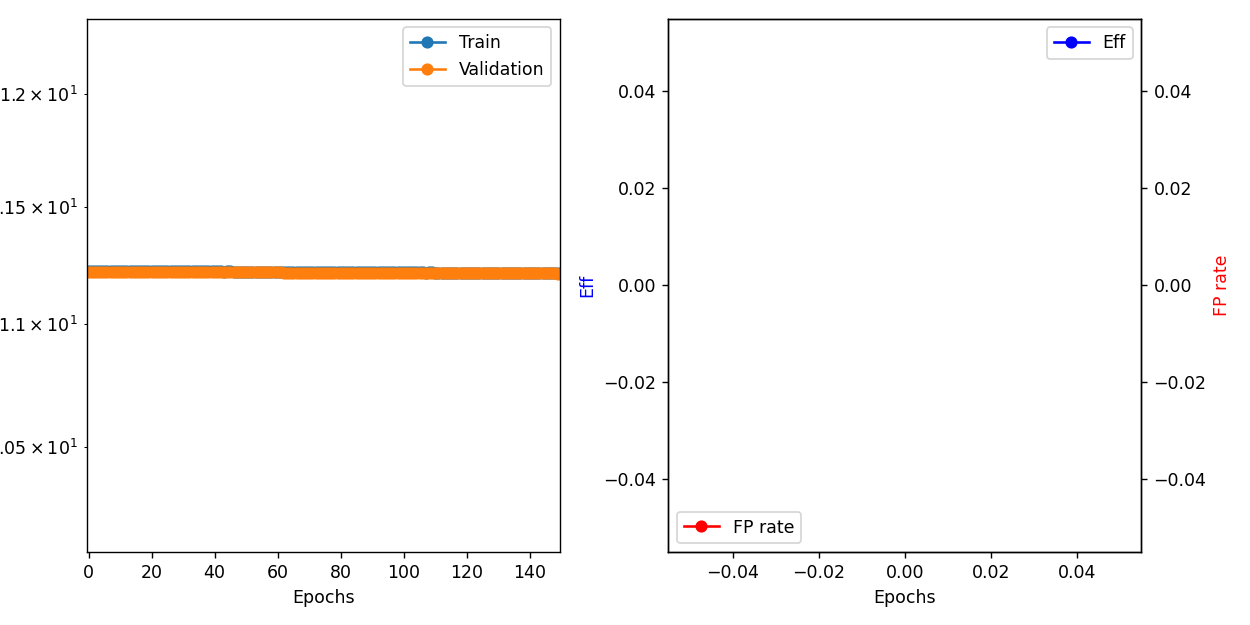

In [16]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [17]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')
    #mine
    param_states.append(get_param_state(model))

Number of batches: train = 1125, val = 125


Number of batches: train = 1125, val = 125


Epoch 0: train=11.2247, val=11.2203, took 37.473 s


Epoch 1: train=11.2247, val=11.2203, took 37.585 s


Epoch 2: train=11.2246, val=11.2202, took 37.476 s


Epoch 3: train=11.2245, val=11.2202, took 37.314 s


Epoch 4: train=11.2244, val=11.2201, took 37.748 s


Epoch 5: train=11.2242, val=11.2201, took 38.613 s


Epoch 6: train=11.2243, val=11.22, took 38.077 s


Epoch 7: train=11.2243, val=11.22, took 37.643 s


Epoch 8: train=11.2242, val=11.22, took 51.043 s


Epoch 9: train=11.2241, val=11.2199, took 76.547 s


Epoch 10: train=11.2241, val=11.2199, took 68.766 s


Epoch 11: train=11.224, val=11.2199, took 38.598 s


Epoch 12: train=11.224, val=11.2197, took 38.731 s


Epoch 13: train=11.2237, val=11.2197, took 39.006 s


Epoch 14: train=11.2237, val=11.2197, took 38.668 s


Epoch 15: train=11.2238, val=11.2196, took 38.544 s


Epoch 16: train=11.2236, val=11.2196, took 38.56 s


Epoch 17: train=11.2234, val=11.2195, took 38.532 s


Epoch 18: train=11.2237, val=11.2195, took 38.623 s


Epoch 19: train=11.2236, val=11.2195, took 38.397 s


Epoch 20: train=11.2233, val=11.2194, took 38.583 s


Epoch 21: train=11.2233, val=11.2193, took 39.66 s


Epoch 22: train=11.2234, val=11.2193, took 38.972 s


Epoch 23: train=11.2233, val=11.2192, took 38.579 s


Epoch 24: train=11.2229, val=11.2193, took 38.755 s


Epoch 25: train=11.223, val=11.2191, took 38.354 s


Epoch 26: train=11.2229, val=11.2192, took 38.095 s


Epoch 27: train=11.2229, val=11.2191, took 38.19 s


Epoch 28: train=11.2226, val=11.219, took 38.567 s


Epoch 29: train=11.2229, val=11.219, took 38.017 s


Epoch 30: train=11.2228, val=11.2189, took 38.635 s


Epoch 31: train=11.2225, val=11.2189, took 39.044 s


Epoch 32: train=11.2225, val=11.2188, took 38.334 s


Epoch 33: train=11.2226, val=11.2188, took 38.657 s


Epoch 34: train=11.2224, val=11.2188, took 38.361 s


Epoch 35: train=11.2224, val=11.2188, took 37.806 s


Epoch 36: train=11.2222, val=11.2187, took 38.184 s


Epoch 37: train=11.2221, val=11.2186, took 37.94 s


Epoch 38: train=11.2223, val=11.2185, took 38.419 s


Epoch 39: train=11.2224, val=11.2185, took 38.403 s


Epoch 40: train=11.222, val=11.2185, took 38.229 s


Epoch 41: train=11.2218, val=11.2185, took 38.987 s


Epoch 42: train=11.2221, val=11.2184, took 38.7 s


Epoch 43: train=11.2217, val=11.2184, took 38.352 s


Epoch 44: train=11.2217, val=11.2184, took 38.215 s


Epoch 45: train=11.2217, val=11.2182, took 38.462 s


Epoch 46: train=11.2216, val=11.2183, took 38.172 s


Epoch 47: train=11.2214, val=11.2181, took 38.351 s


Epoch 48: train=11.2216, val=11.2181, took 38.154 s


Epoch 49: train=11.2216, val=11.2181, took 38.757 s


Epoch 50: train=11.2213, val=11.218, took 37.965 s


Epoch 51: train=11.2214, val=11.2179, took 38.336 s


Epoch 52: train=11.2212, val=11.2179, took 38.177 s


Epoch 53: train=11.2212, val=11.2179, took 38.127 s


Epoch 54: train=11.2212, val=11.2179, took 37.592 s


Epoch 55: train=11.221, val=11.2178, took 38.52 s


Epoch 56: train=11.2211, val=11.2178, took 38.13 s


Epoch 57: train=11.2209, val=11.2177, took 38.233 s


Epoch 58: train=11.221, val=11.2177, took 38.76 s


Epoch 59: train=11.2209, val=11.2176, took 39.329 s


Epoch 60: train=11.2205, val=11.2175, took 38.421 s


Epoch 61: train=11.2206, val=11.2176, took 38.454 s


Epoch 62: train=11.2206, val=11.2175, took 38.572 s


Epoch 63: train=11.2206, val=11.2175, took 38.317 s


Epoch 64: train=11.2206, val=11.2174, took 37.855 s


Epoch 65: train=11.2202, val=11.2174, took 38.408 s


Epoch 66: train=11.2202, val=11.2173, took 38.622 s


Epoch 67: train=11.2203, val=11.2173, took 38.91 s


Epoch 68: train=11.2202, val=11.2172, took 37.829 s


Epoch 69: train=11.2201, val=11.2172, took 38.858 s


Epoch 70: train=11.2201, val=11.2171, took 39.905 s


Epoch 71: train=11.2202, val=11.2172, took 39.005 s


Epoch 72: train=11.2201, val=11.217, took 39.336 s


Epoch 73: train=11.2198, val=11.217, took 38.896 s


Epoch 74: train=11.2196, val=11.217, took 38.497 s


Epoch 75: train=11.2198, val=11.2169, took 38.085 s


Epoch 76: train=11.2196, val=11.2169, took 37.965 s


Epoch 77: train=11.2198, val=11.2169, took 38.262 s


Epoch 78: train=11.2196, val=11.2168, took 37.955 s


Epoch 79: train=11.2193, val=11.2167, took 37.852 s


Epoch 80: train=11.2195, val=11.2166, took 37.832 s


Epoch 81: train=11.2194, val=11.2166, took 37.826 s


Epoch 82: train=11.2193, val=11.2166, took 37.813 s


Epoch 83: train=11.2191, val=11.2166, took 37.736 s


Epoch 84: train=11.219, val=11.2166, took 37.845 s


Epoch 85: train=11.2191, val=11.2165, took 38.731 s


Epoch 86: train=11.2192, val=11.2164, took 38.224 s


Epoch 87: train=11.2188, val=11.2163, took 37.84 s


Epoch 88: train=11.219, val=11.2163, took 38.208 s


Epoch 89: train=11.2186, val=11.2163, took 38.409 s


Epoch 90: train=11.2185, val=11.2163, took 38.072 s


Epoch 91: train=11.2189, val=11.2161, took 37.851 s


Epoch 92: train=11.2185, val=11.2161, took 37.959 s


Epoch 93: train=11.2187, val=11.2161, took 38.052 s


Epoch 94: train=11.2186, val=11.216, took 38.332 s


Epoch 95: train=11.2184, val=11.216, took 38.218 s


Epoch 96: train=11.2184, val=11.216, took 37.862 s


Epoch 97: train=11.2183, val=11.2159, took 37.834 s


Epoch 98: train=11.2183, val=11.2158, took 37.88 s


Epoch 99: train=11.2182, val=11.2158, took 37.733 s


Epoch 100: train=11.2178, val=11.2157, took 38.427 s


Epoch 101: train=11.2178, val=11.2157, took 38.251 s


Epoch 102: train=11.2178, val=11.2156, took 38.069 s


Epoch 103: train=11.2176, val=11.2156, took 38.152 s


Epoch 104: train=11.2179, val=11.2155, took 38.015 s


Epoch 105: train=11.2176, val=11.2155, took 37.716 s


Epoch 106: train=11.2175, val=11.2154, took 38.123 s


Epoch 107: train=11.2174, val=11.2154, took 37.837 s


Epoch 108: train=11.2176, val=11.2154, took 37.955 s


Epoch 109: train=11.2178, val=11.2153, took 37.997 s


Epoch 110: train=11.2173, val=11.2153, took 38.578 s


Epoch 111: train=11.2172, val=11.2153, took 38.488 s


Epoch 112: train=11.2174, val=11.2152, took 38.318 s


Epoch 113: train=11.2171, val=11.2152, took 38.446 s


Epoch 114: train=11.217, val=11.2151, took 37.986 s


Epoch 115: train=11.2171, val=11.215, took 38.094 s


Epoch 116: train=11.2173, val=11.215, took 37.959 s


Epoch 117: train=11.2166, val=11.2149, took 38.029 s


Epoch 118: train=11.2168, val=11.2149, took 38.154 s


Epoch 119: train=11.2168, val=11.2149, took 38.325 s


Epoch 120: train=11.2165, val=11.2149, took 38.489 s


Epoch 121: train=11.2167, val=11.2147, took 38.283 s


Epoch 122: train=11.2166, val=11.2147, took 38.448 s


Epoch 123: train=11.2165, val=11.2147, took 38.114 s


Epoch 124: train=11.2163, val=11.2146, took 38.464 s


Epoch 125: train=11.2164, val=11.2146, took 38.257 s


Epoch 126: train=11.2162, val=11.2146, took 38.099 s


Epoch 127: train=11.2159, val=11.2145, took 38.377 s


Epoch 128: train=11.2161, val=11.2144, took 38.09 s


Epoch 129: train=11.2159, val=11.2144, took 38.526 s


Epoch 130: train=11.216, val=11.2144, took 38.022 s


Epoch 131: train=11.2159, val=11.2143, took 37.931 s


Epoch 132: train=11.2158, val=11.2142, took 38.076 s


Epoch 133: train=11.2156, val=11.2142, took 38.064 s


Epoch 134: train=11.2154, val=11.2141, took 38.133 s


Epoch 135: train=11.2155, val=11.214, took 38.163 s


Epoch 136: train=11.2153, val=11.214, took 38.276 s


Epoch 137: train=11.2152, val=11.2139, took 38.272 s


Epoch 138: train=11.2151, val=11.2138, took 37.909 s


Epoch 139: train=11.2154, val=11.2138, took 38.8 s


Epoch 140: train=11.2153, val=11.2138, took 38.153 s


Epoch 141: train=11.2151, val=11.2137, took 38.316 s


Epoch 142: train=11.2151, val=11.2136, took 38.59 s


Epoch 143: train=11.2152, val=11.2136, took 38.292 s


Epoch 144: train=11.2151, val=11.2135, took 38.291 s


Epoch 145: train=11.2149, val=11.2134, took 37.902 s


Epoch 146: train=11.2148, val=11.2133, took 38.431 s


Epoch 147: train=11.2147, val=11.2133, took 38.166 s


Epoch 148: train=11.2148, val=11.2133, took 38.298 s


Epoch 149: train=11.2145, val=11.2131, took 38.018 s



Go ahead and save the final model (even though it was also saved above):

In [18]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [19]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

<IPython.core.display.Javascript object>


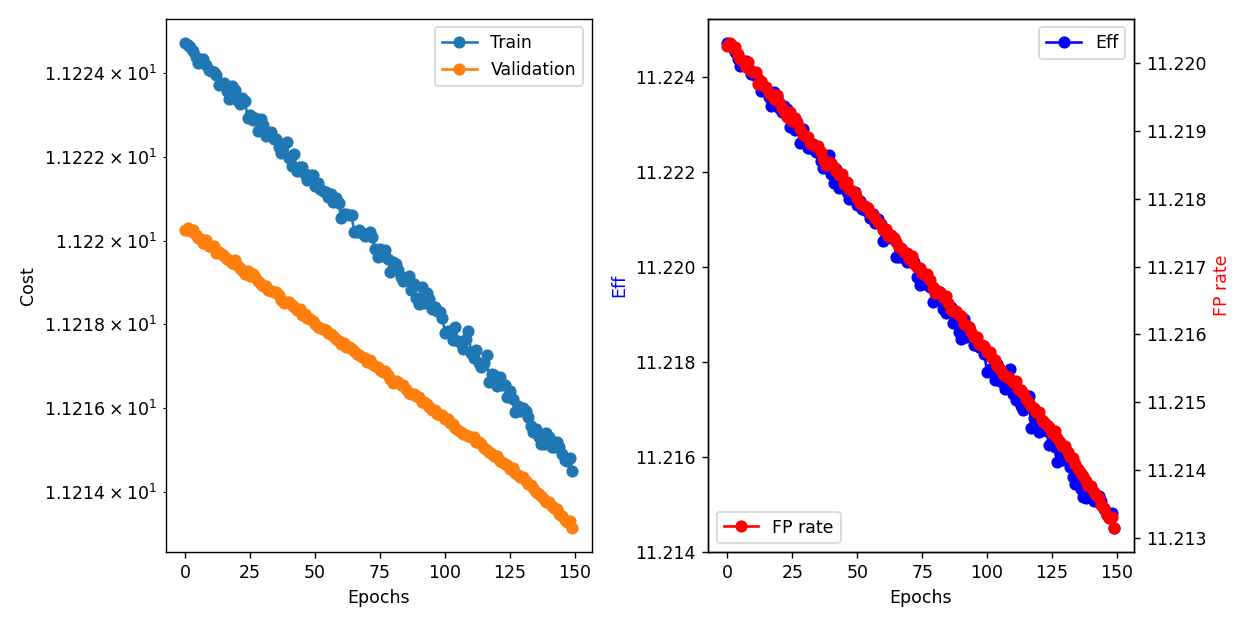

In [20]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [21]:
from functions.utils import state_dict_to_vector
def angle_between(a, b):
    return np.arccos(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))

angle_grids = []
grid_size = 25
num_epochs = n_epochs
num_epochs2 = 0

ep_intervals = [(np.arange(0, num_epochs+num_epochs2+1, grid_size)[i], np.arange(0, num_epochs+num_epochs2+1, grid_size)[i+1]) for i in range(len(np.arange(0, num_epochs+num_epochs2+1, grid_size))-1)]

for interval in ep_intervals:
    
    these_param_states = []
    for i in range(interval[0], interval[1]):
        if i % 100 == 0:
            print(i)
        these_param_states.append(param_states[i])
        #print("Loaded", file_names[i])
        
    interval_size = len(these_param_states)-1    
    these_steps = [these_param_states[i+1]-these_param_states[i] for i in range(interval_size)]
    
    this_angle_grid = np.zeros((interval_size, interval_size))
    
    for i in range(interval_size):
        for j in range(i+1, interval_size):#range(i+1, interval_size):
            angle = angle_between(these_steps[i], these_steps[j])
            this_angle_grid[i,j] = angle
            this_angle_grid[j,i] = angle
            
    angle_grids.append(this_angle_grid)

0
100


<IPython.core.display.Javascript object>


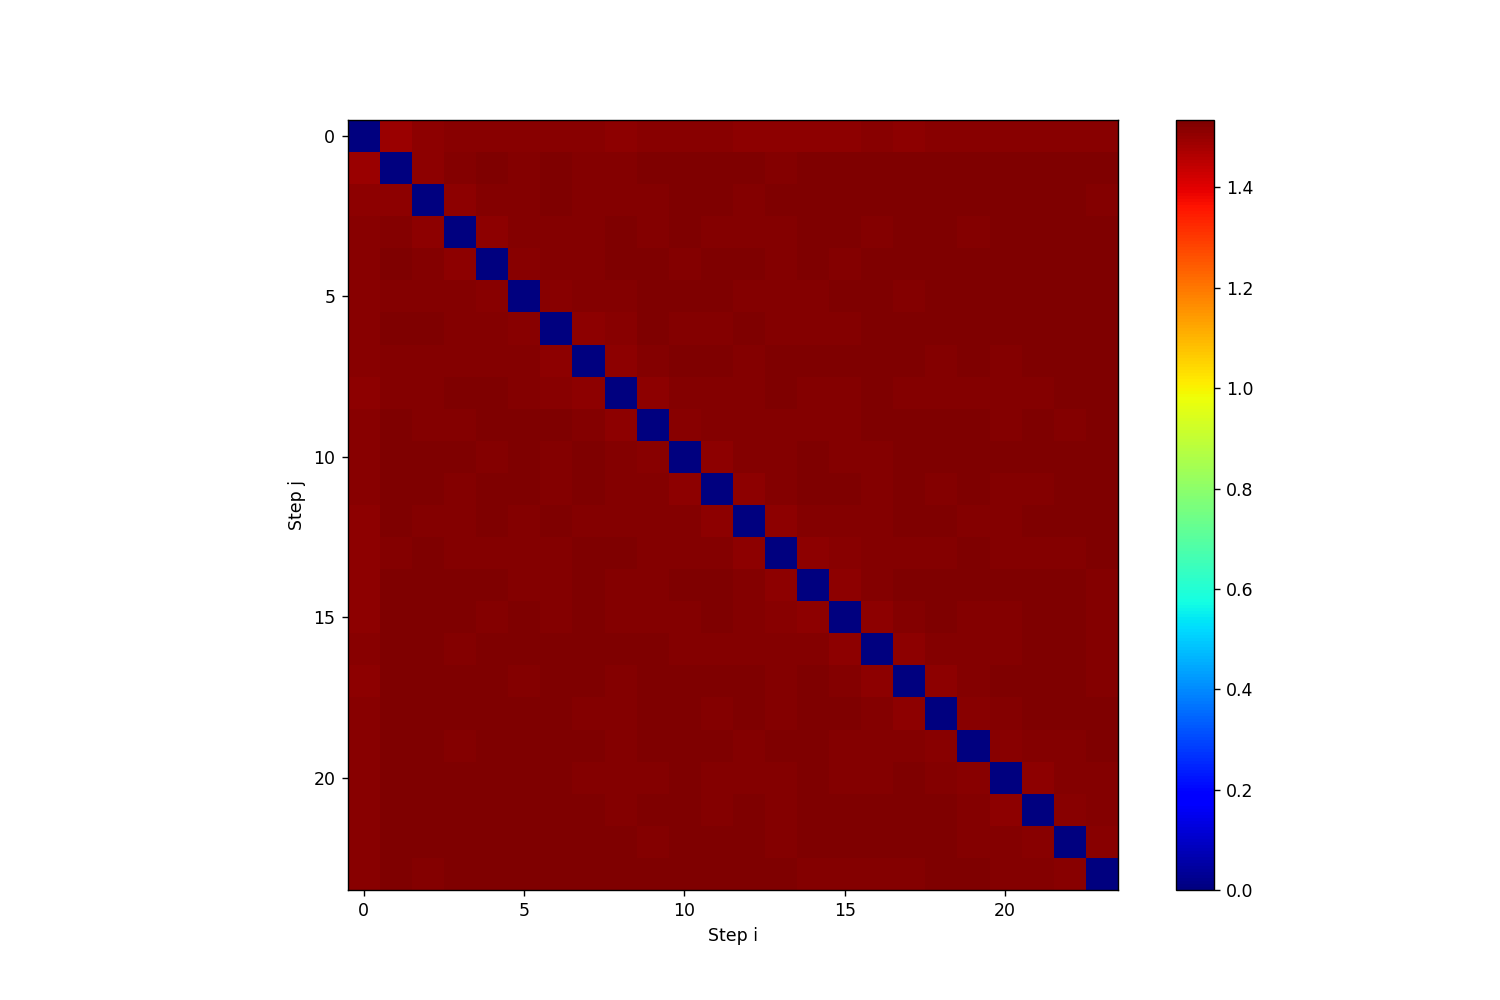

<IPython.core.display.Javascript object>


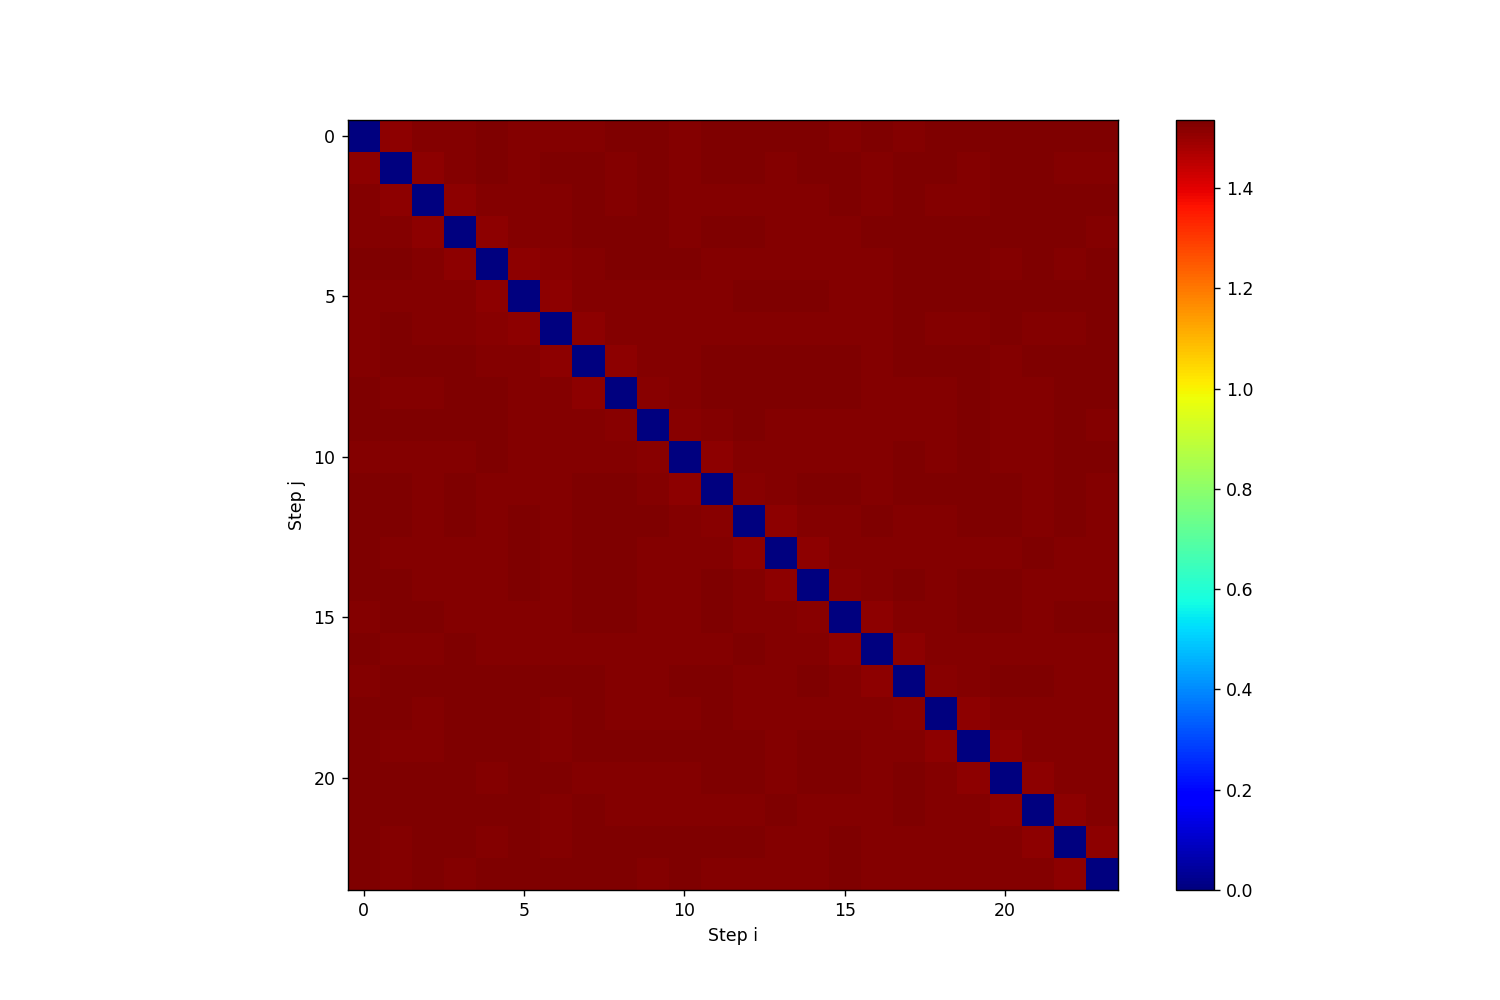

<IPython.core.display.Javascript object>


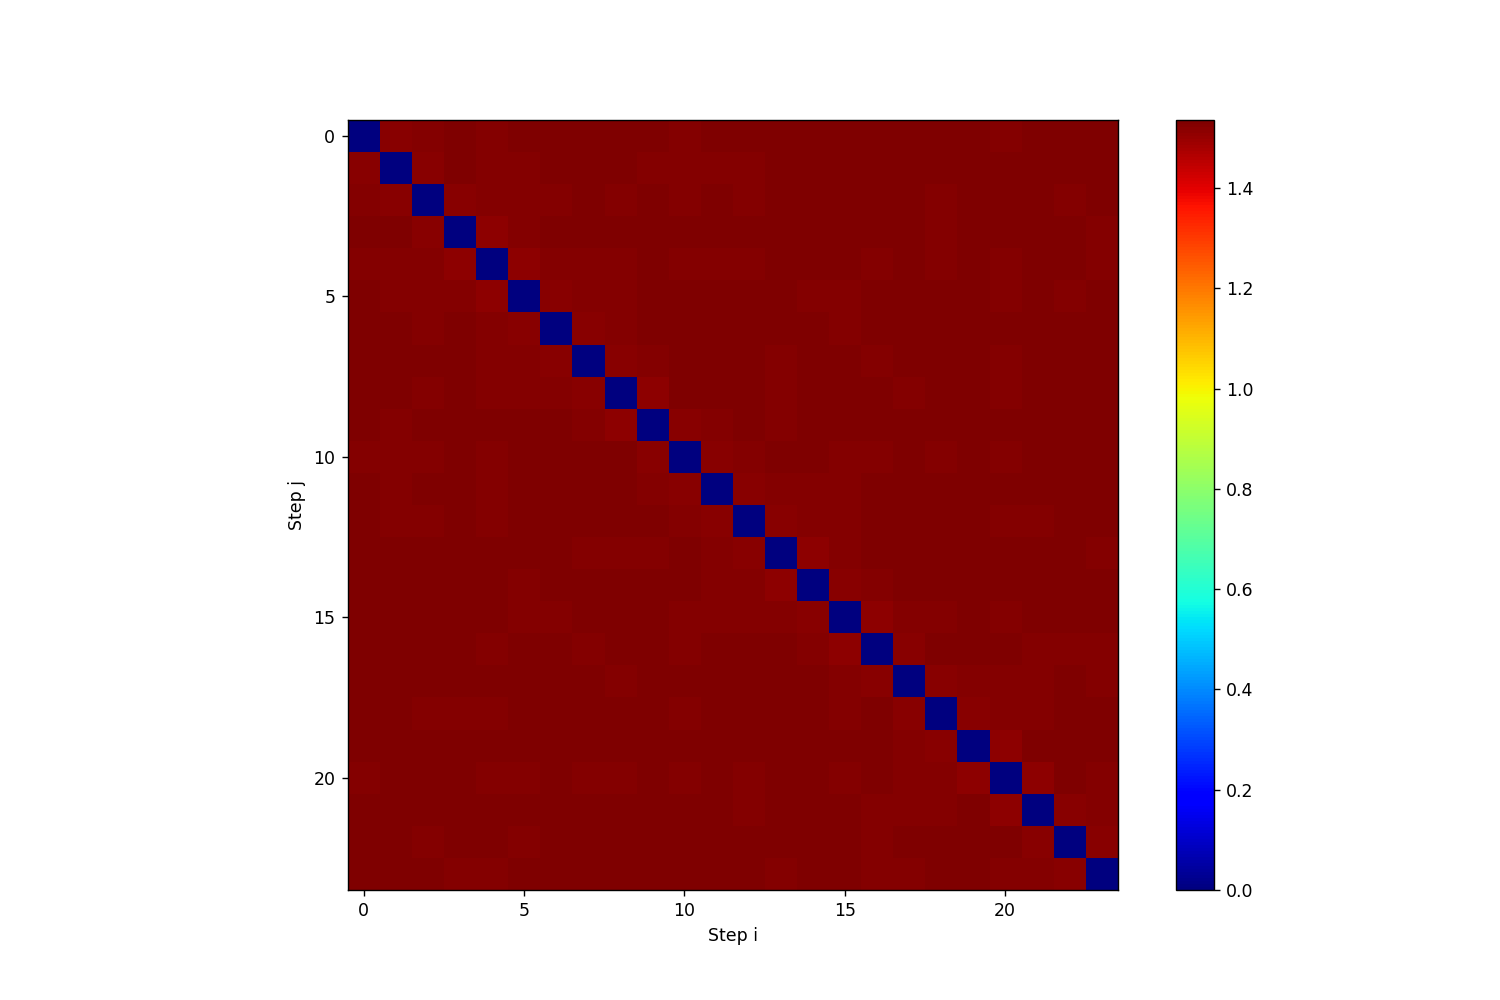

<IPython.core.display.Javascript object>


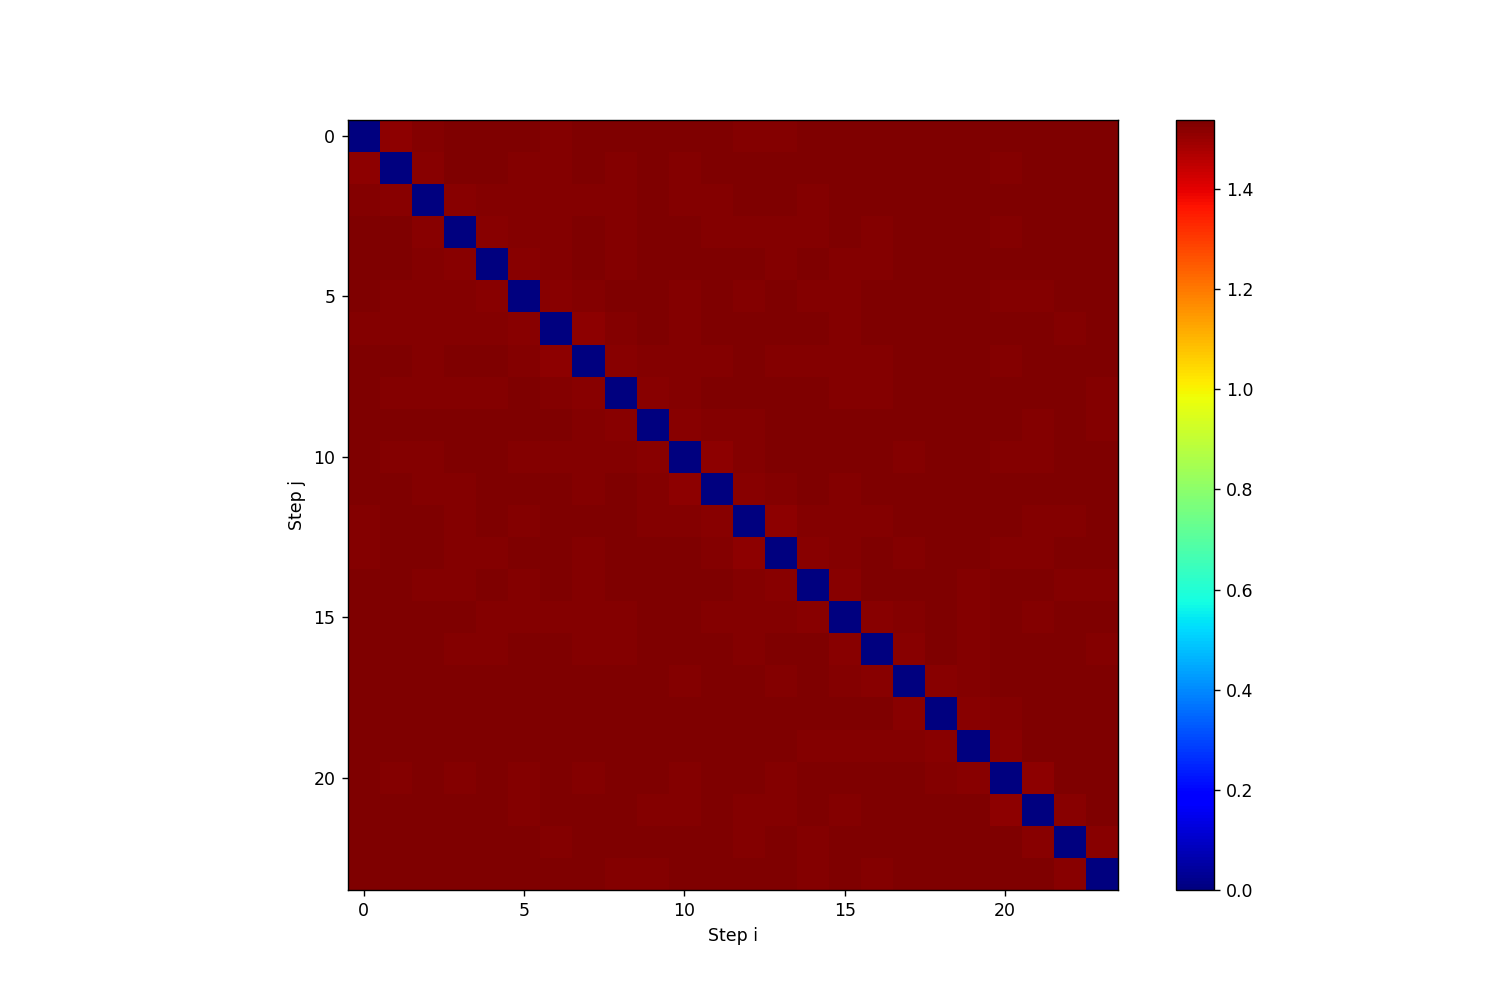

<IPython.core.display.Javascript object>


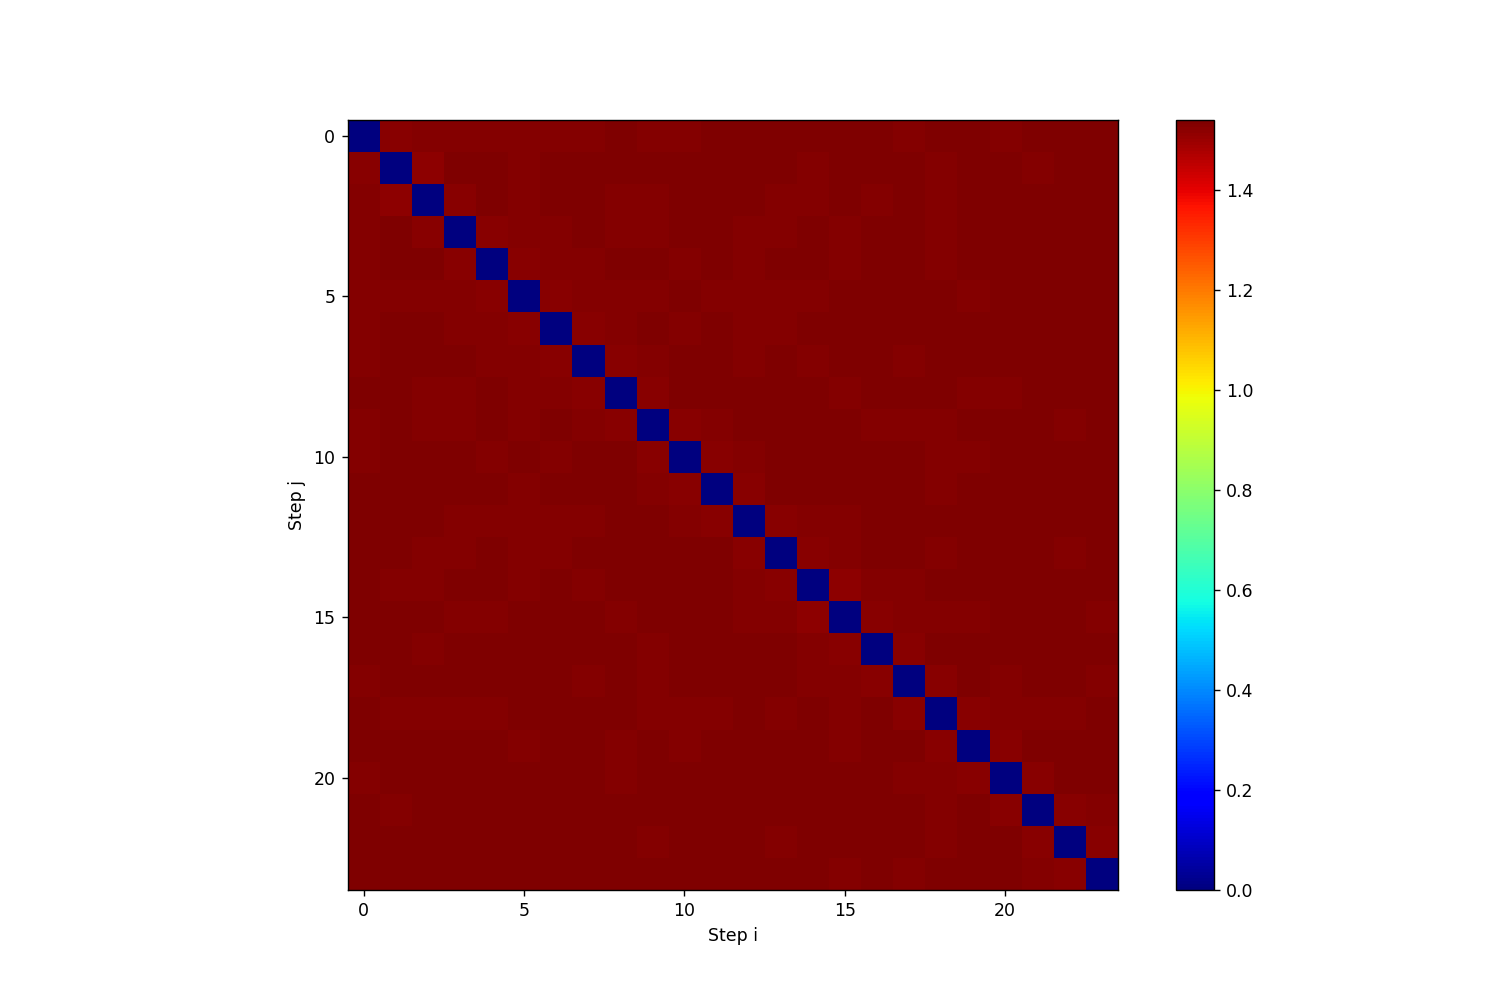

<IPython.core.display.Javascript object>


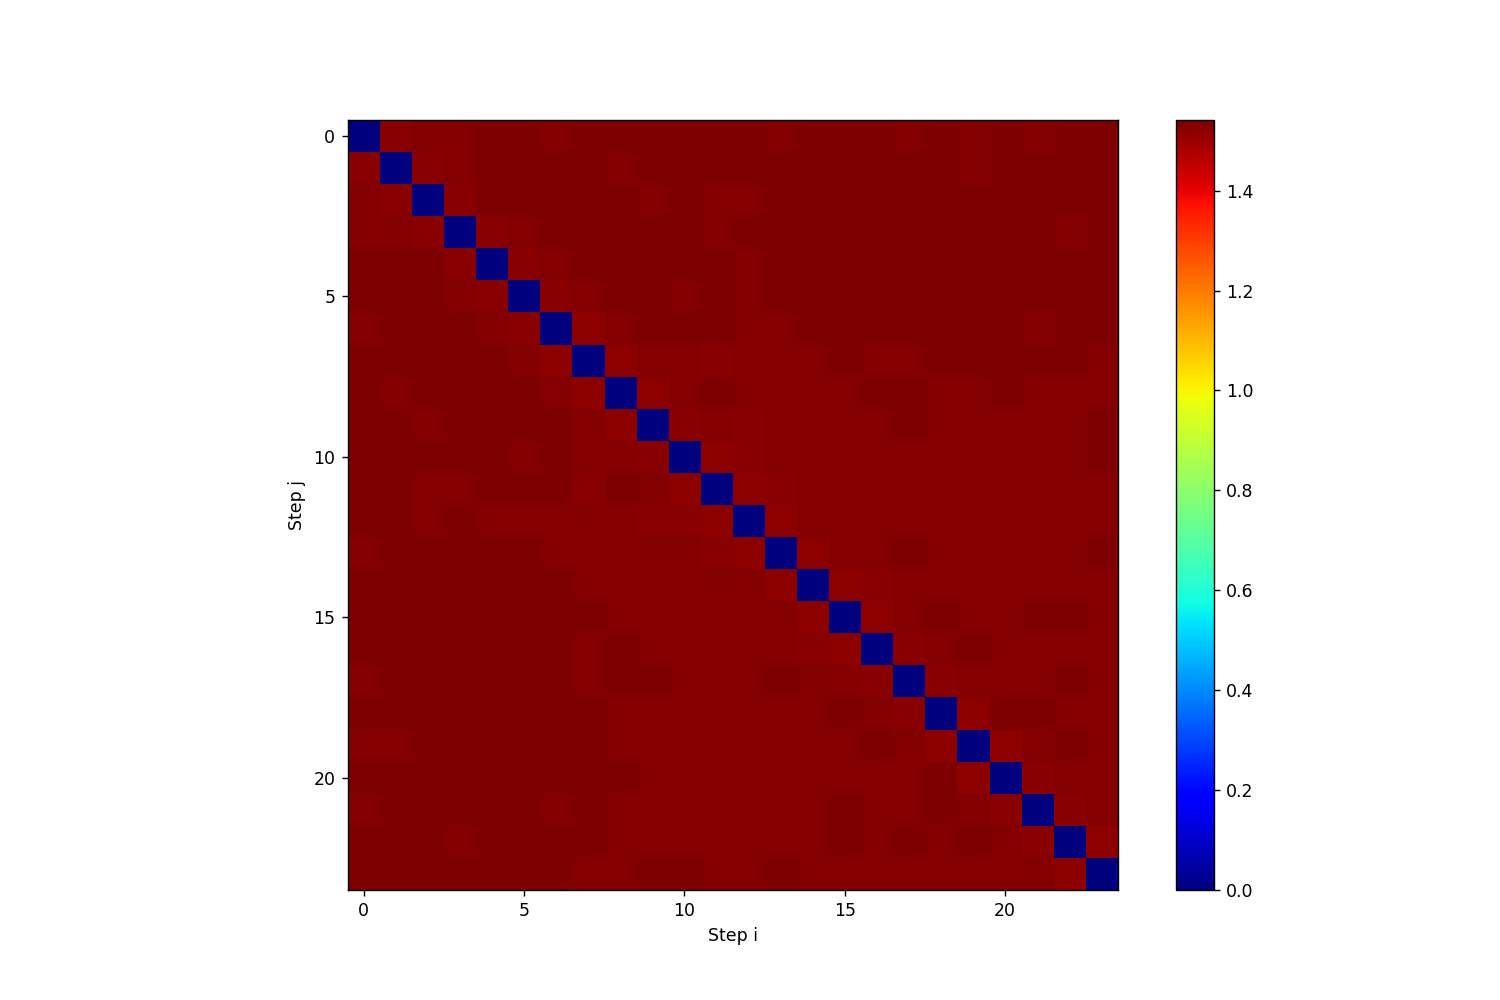

In [22]:
import matplotlib.colors as colors
import matplotlib.cm as cm

for angle_grid in angle_grids:
    plt.figure(figsize=(12,8))
    norm = colors.Normalize(vmin=np.amin(angle_grid), vmax=np.amax(angle_grid))   
    plt.imshow(angle_grid, cmap=cm.jet)
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet))
    plt.xlabel('Step i')
    plt.ylabel('Step j')
    
#print("num params:", len(these_param_states[0]))

In [23]:
from functions.plotting_DDplus_hists import load_data
from functions.utils import vector_to_state_dict

state_dicts = []
# num_epochs = 500
for i in np.arange(0, num_epochs, 10):
    state_dicts.append( (i, vector_to_state_dict(param_states[i], model)) )

data = load_data()

Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] = 

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]


<IPython.core.display.Javascript object>


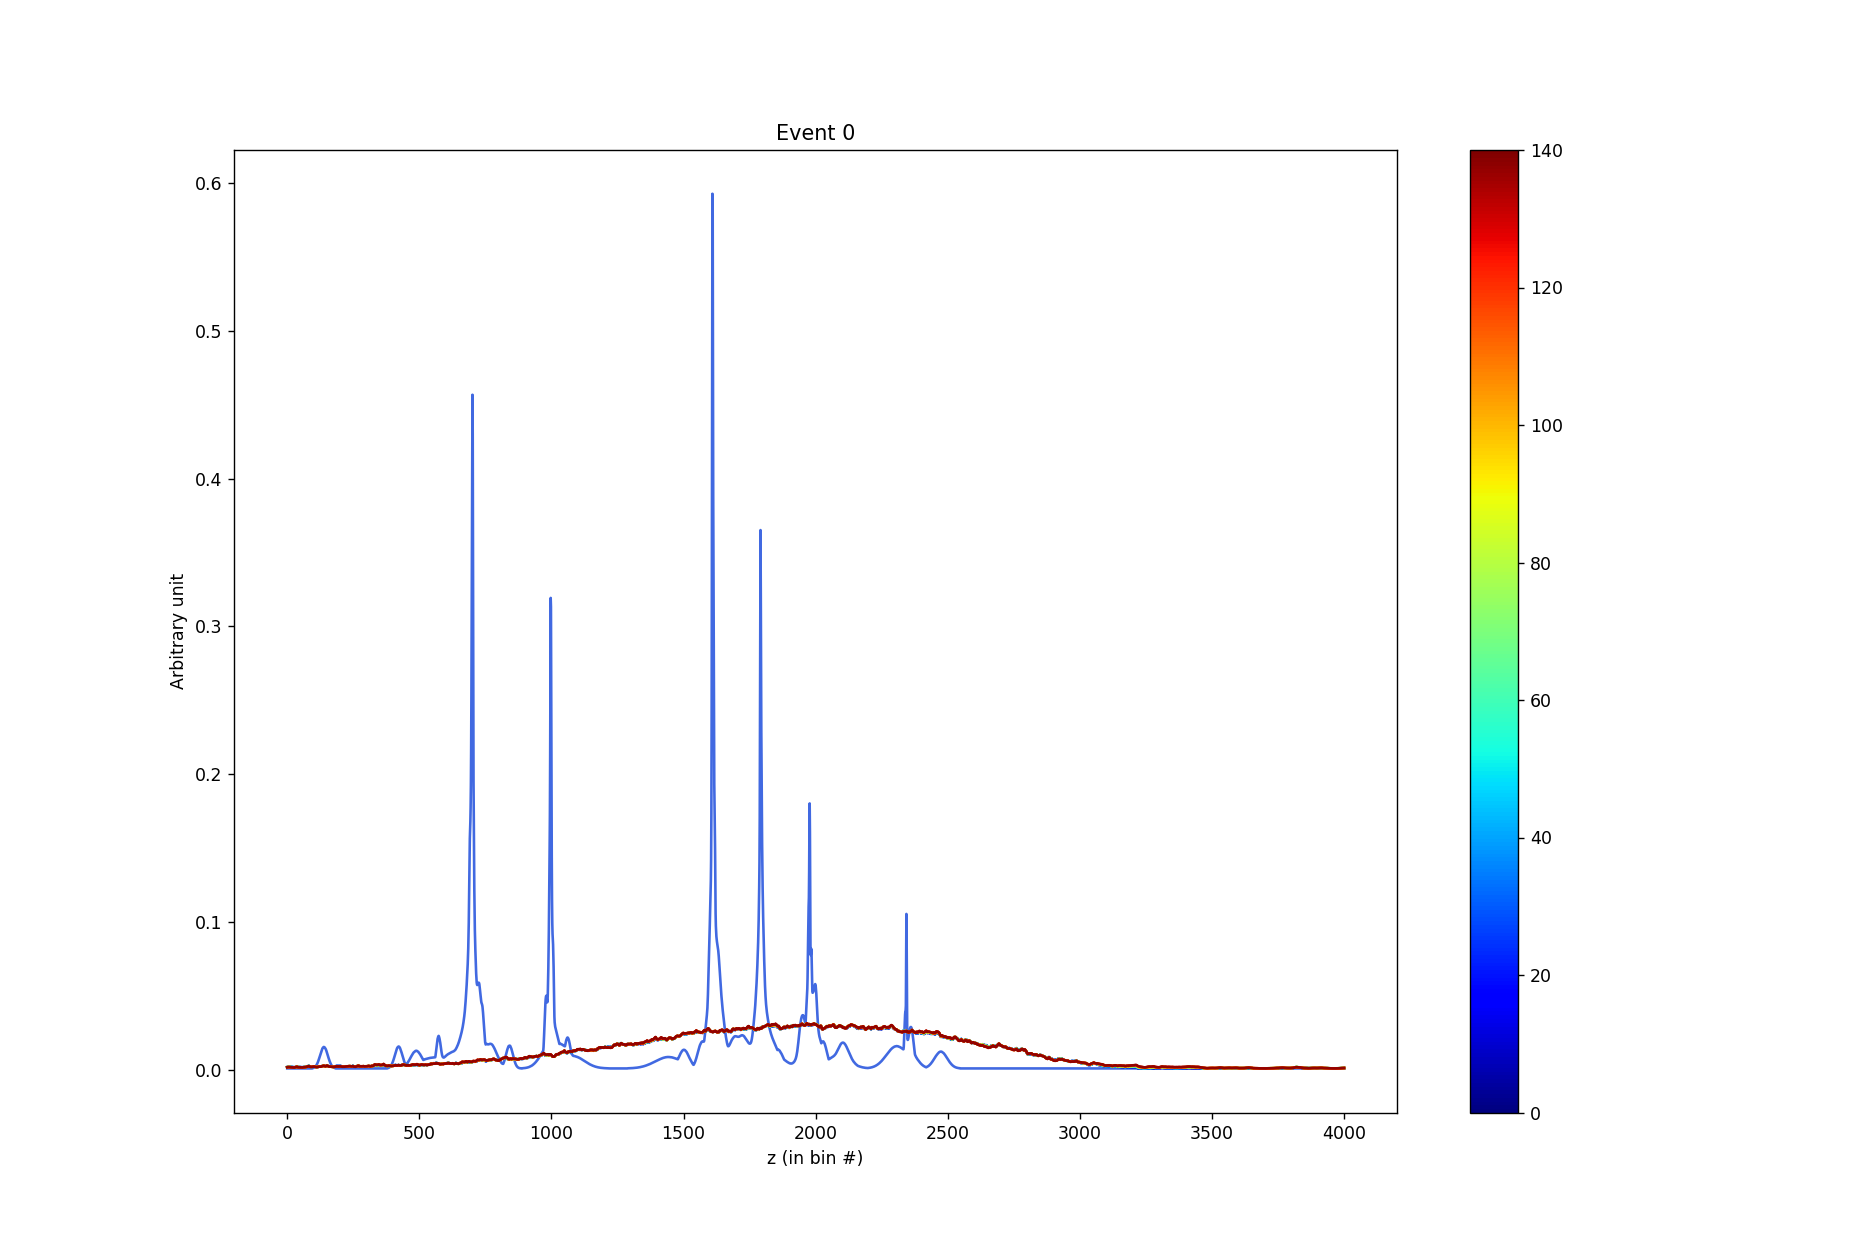

<IPython.core.display.Javascript object>


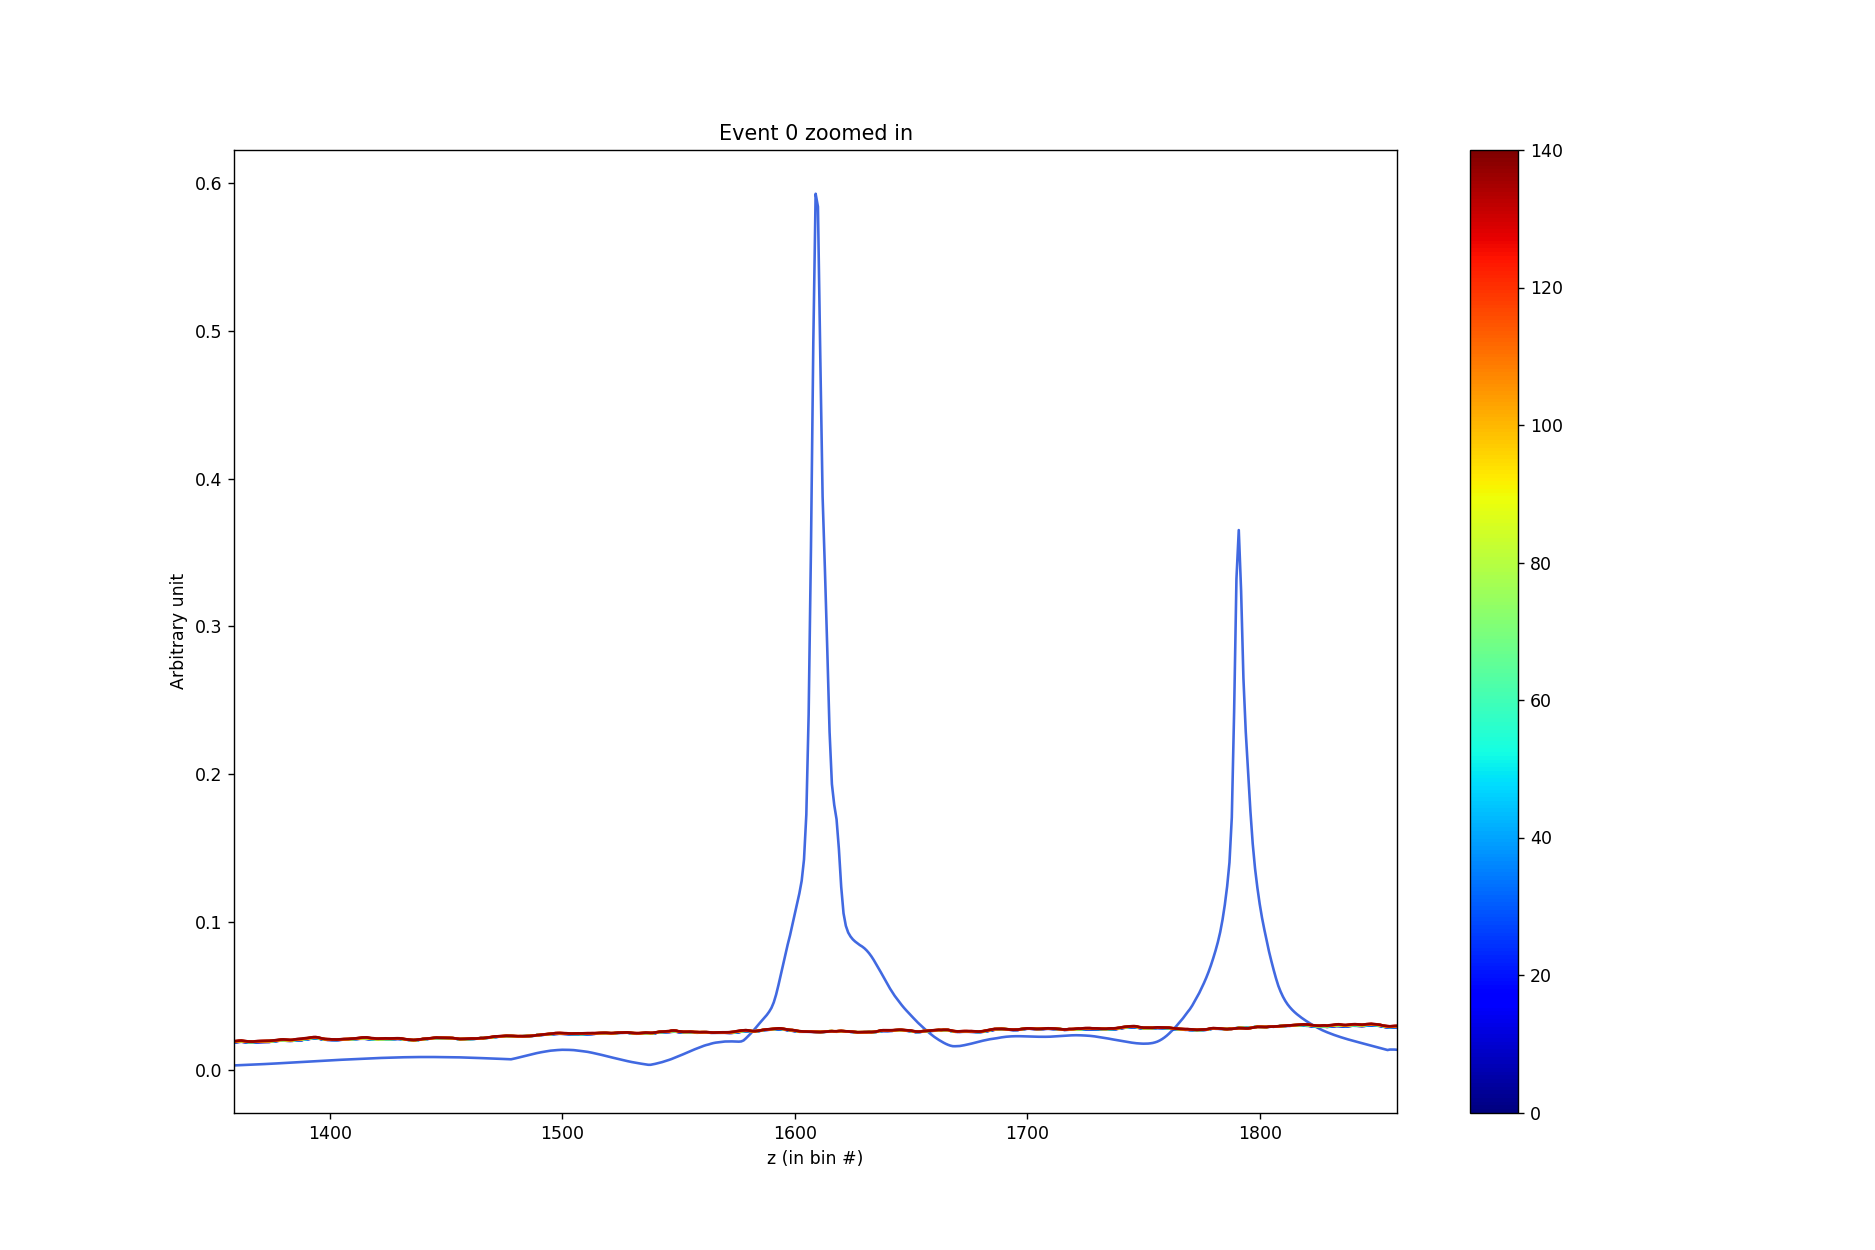

<IPython.core.display.Javascript object>


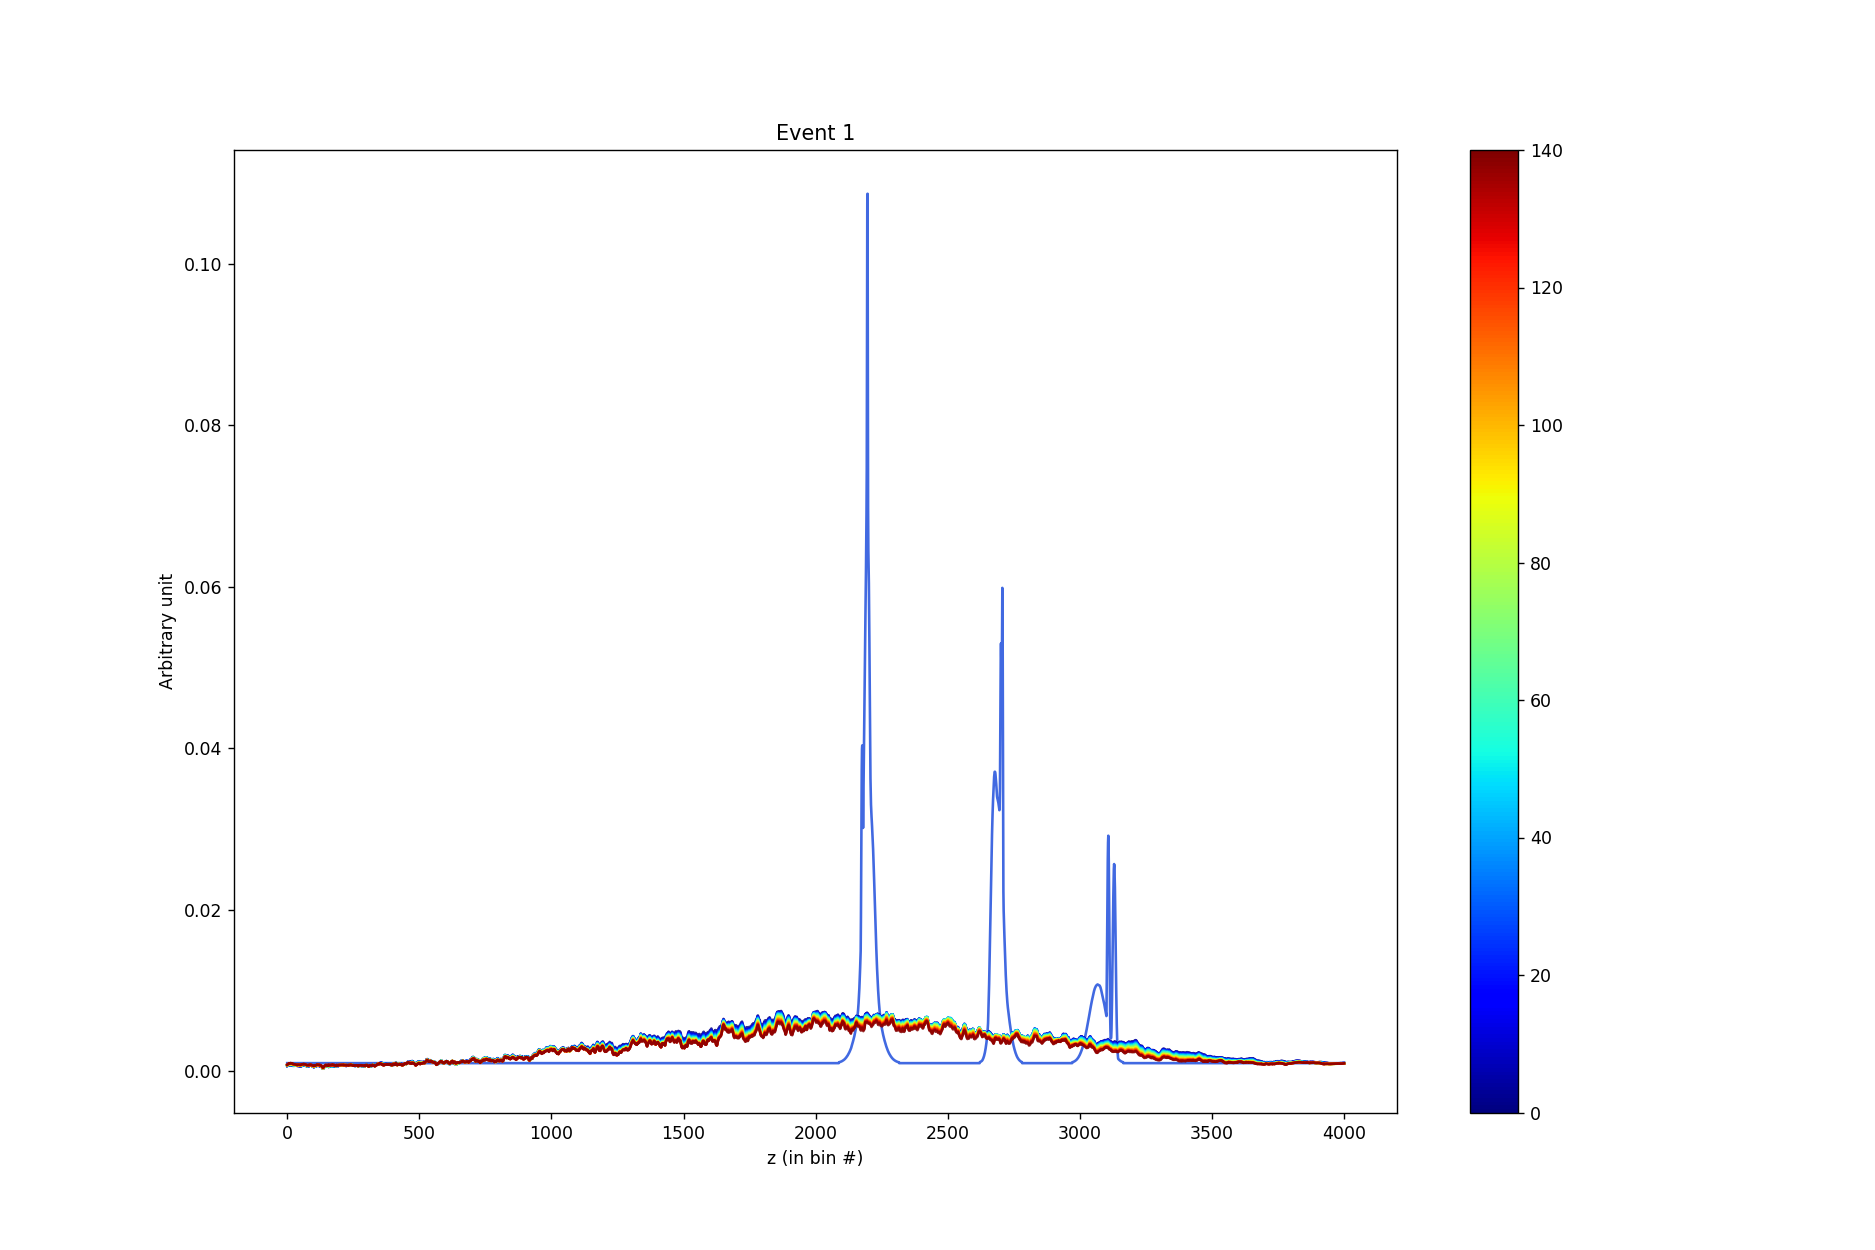

<IPython.core.display.Javascript object>


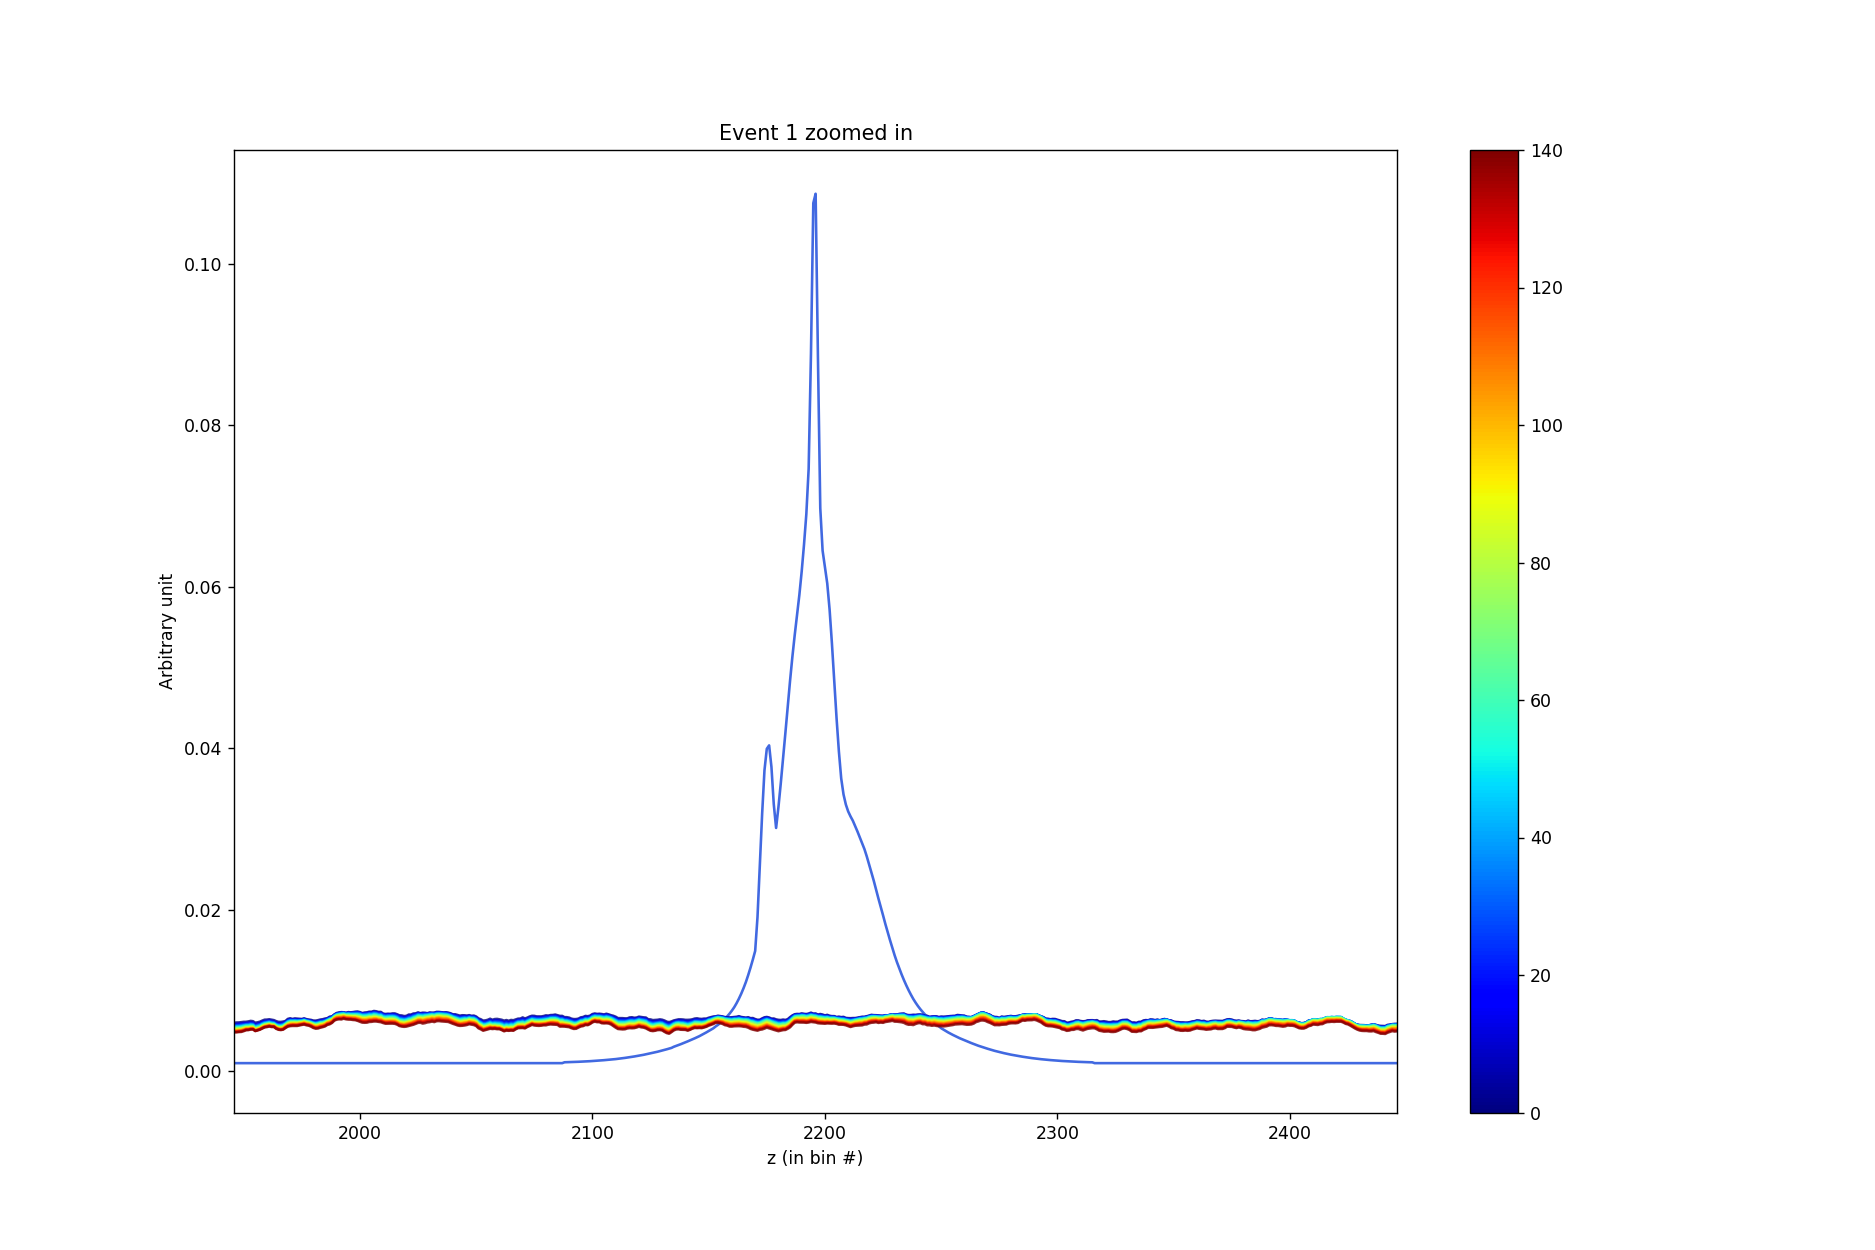

<IPython.core.display.Javascript object>


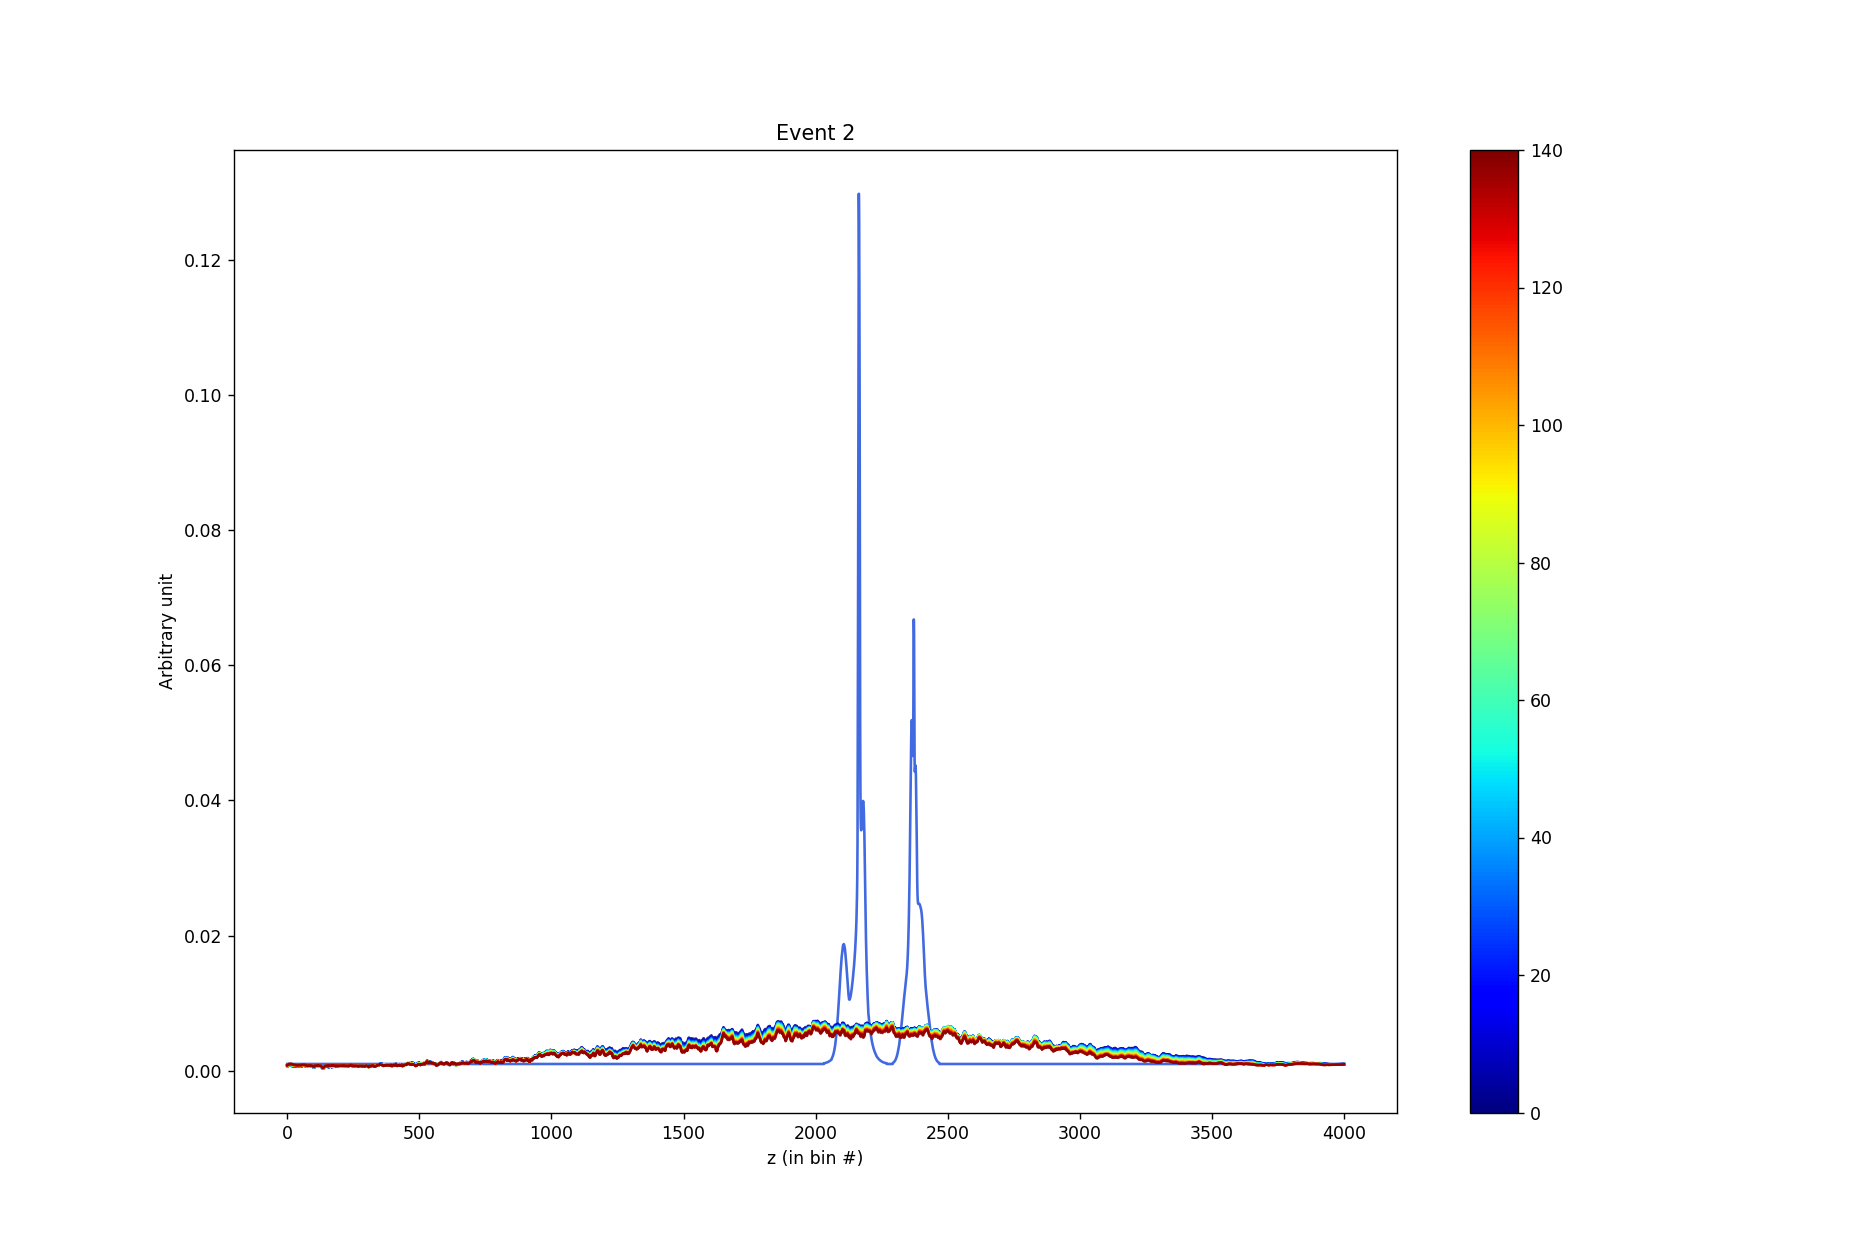

<IPython.core.display.Javascript object>


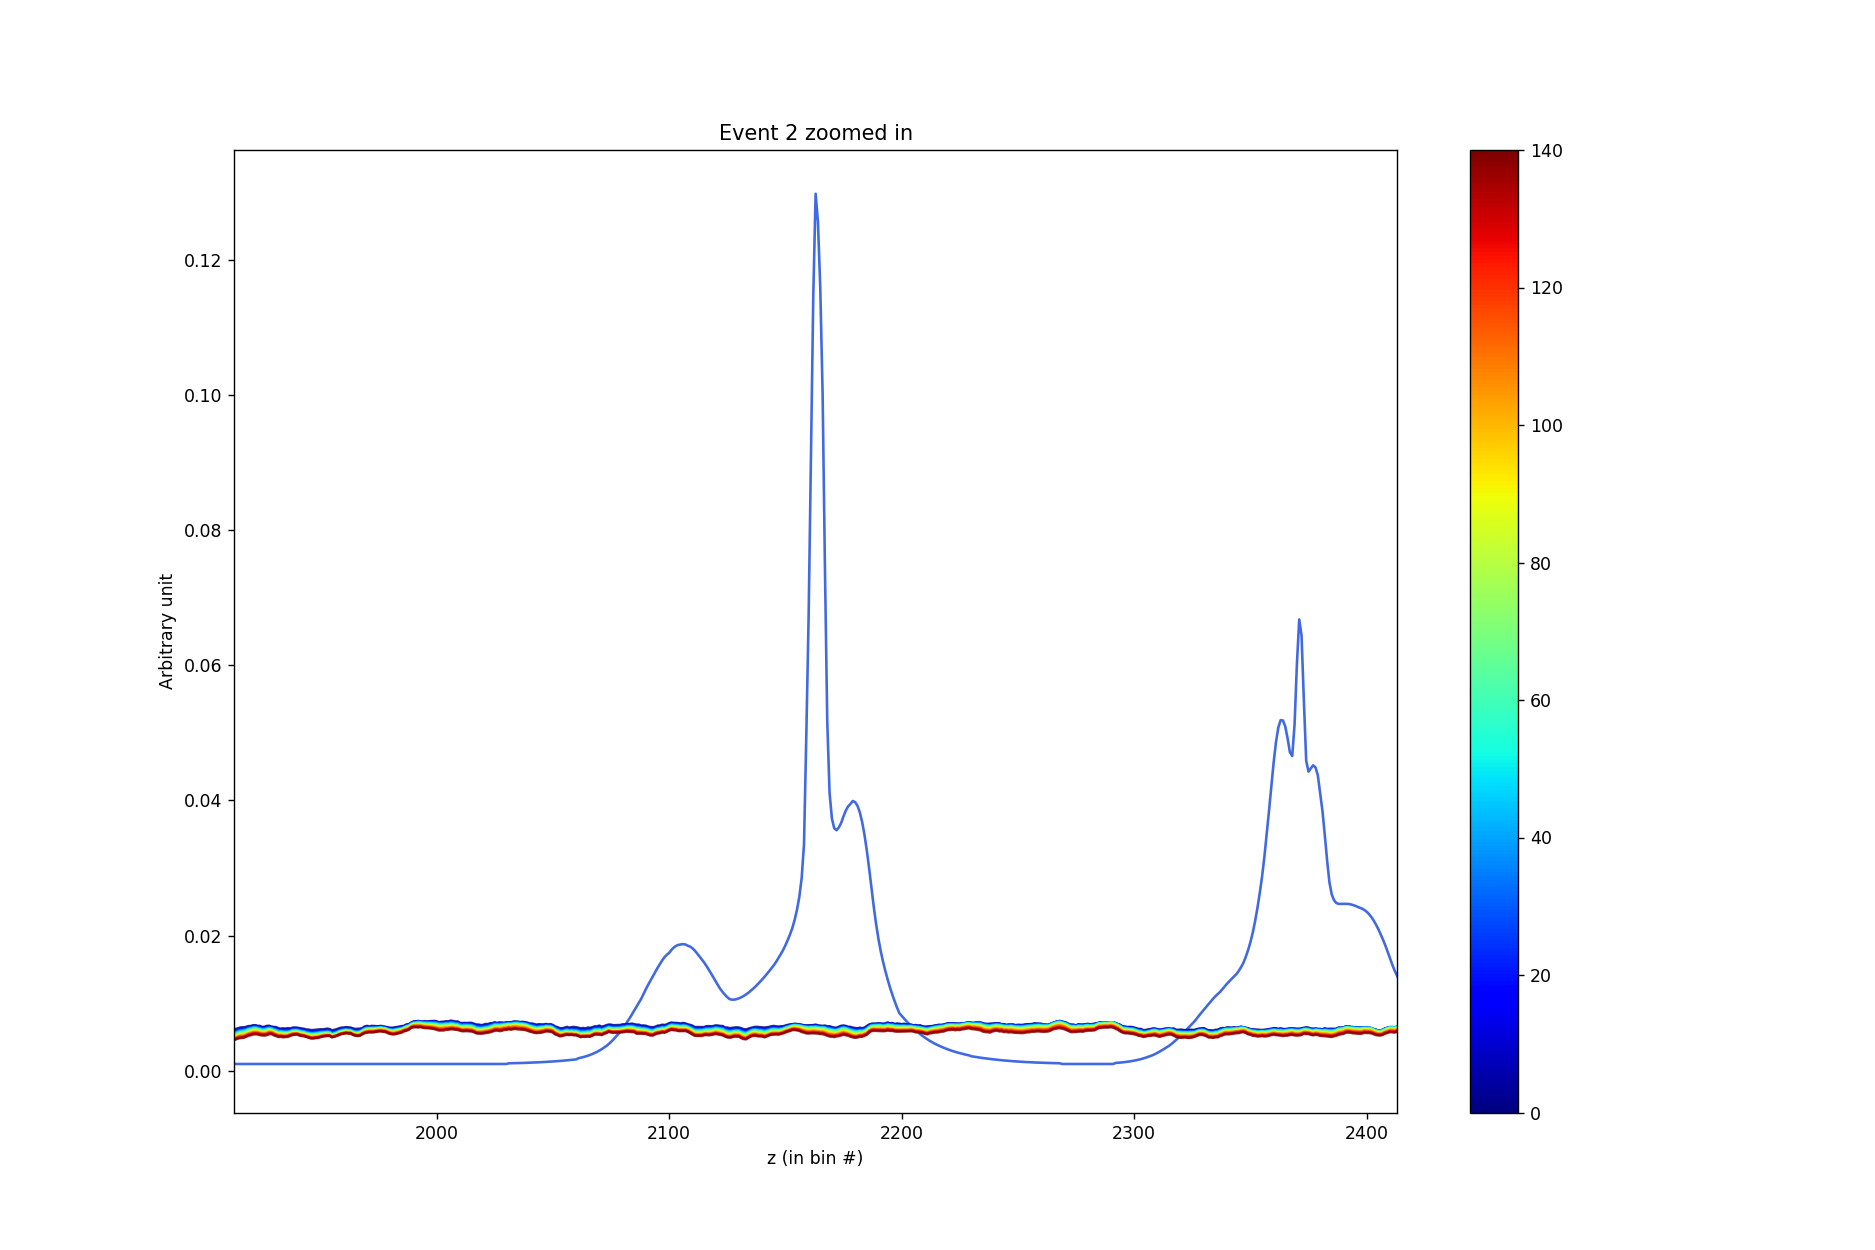

<IPython.core.display.Javascript object>


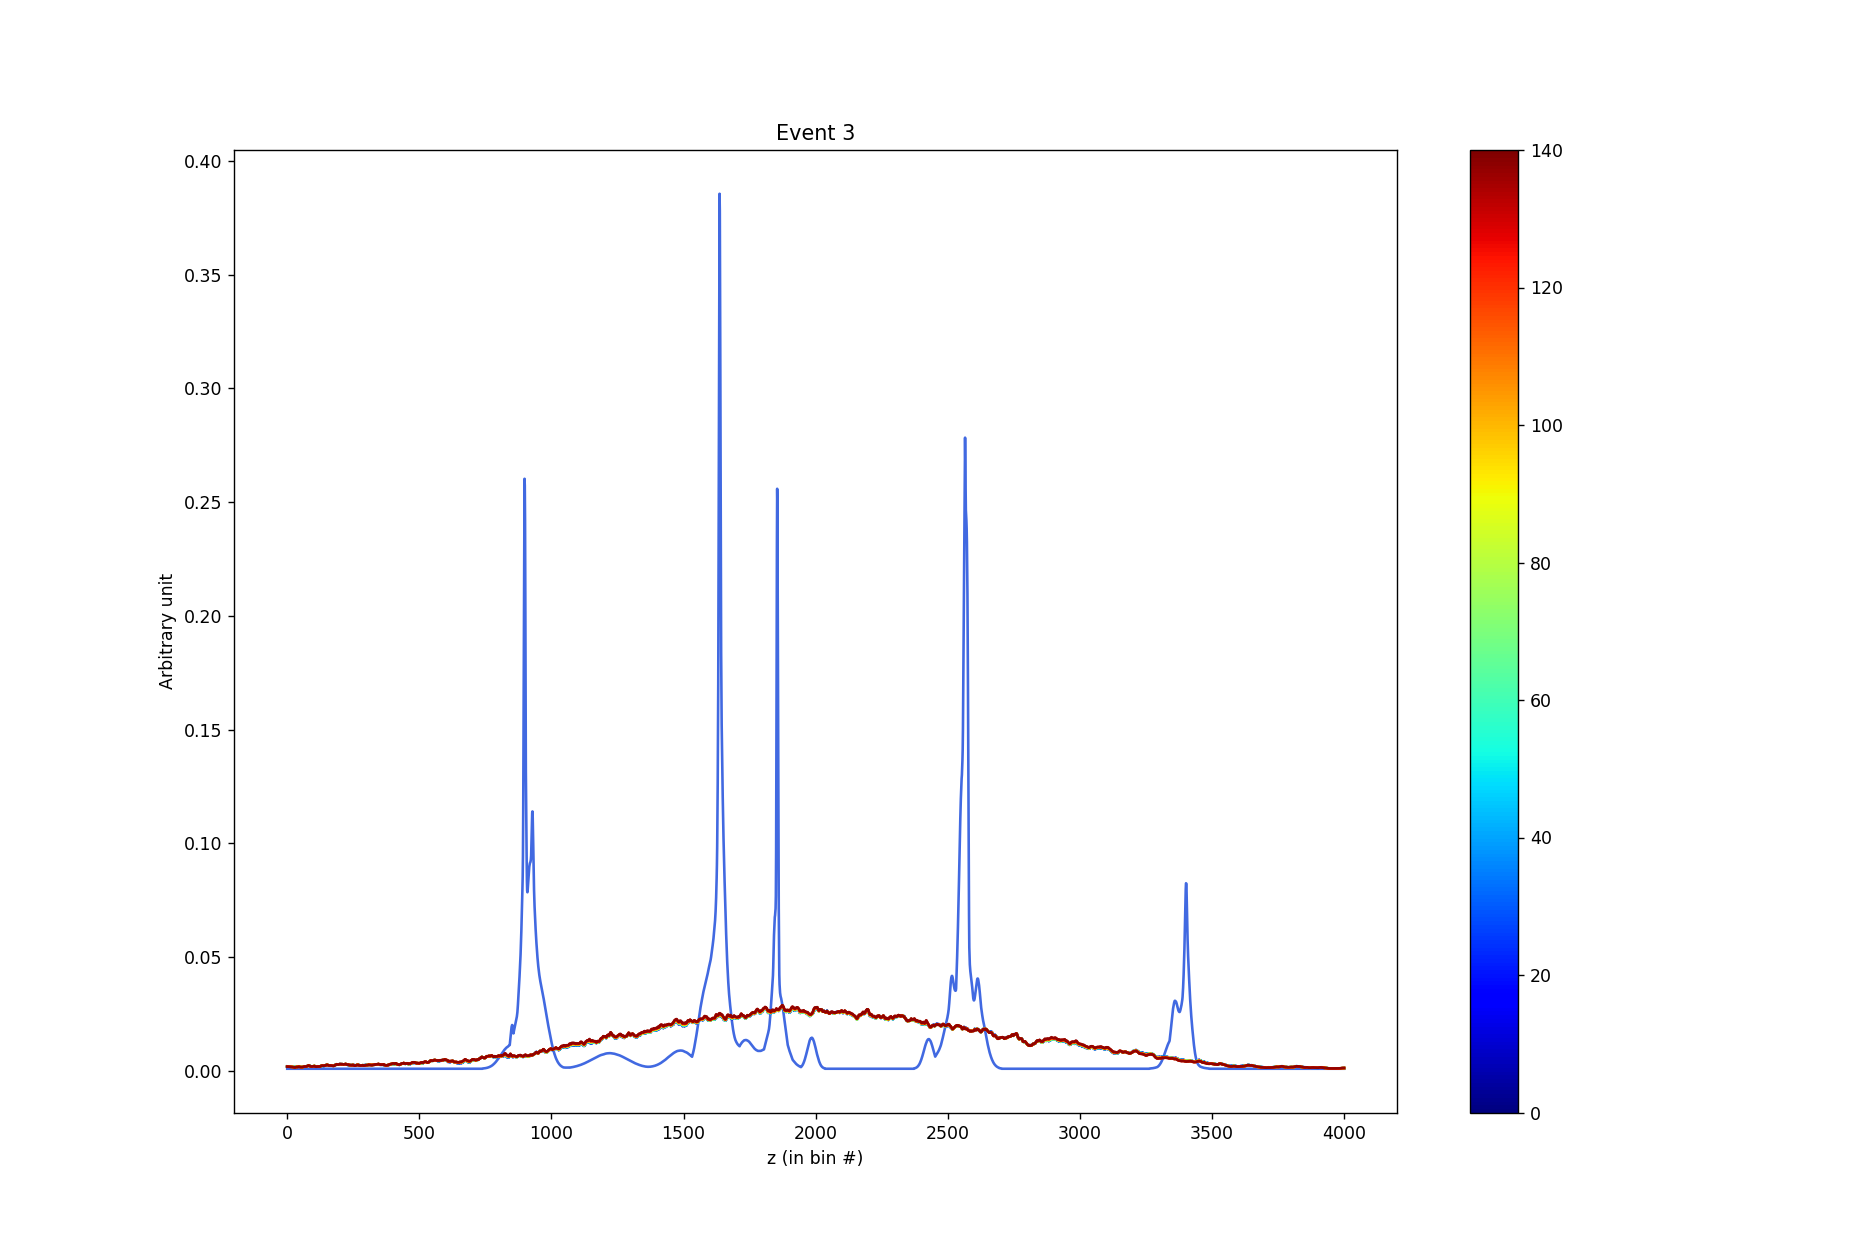

<IPython.core.display.Javascript object>


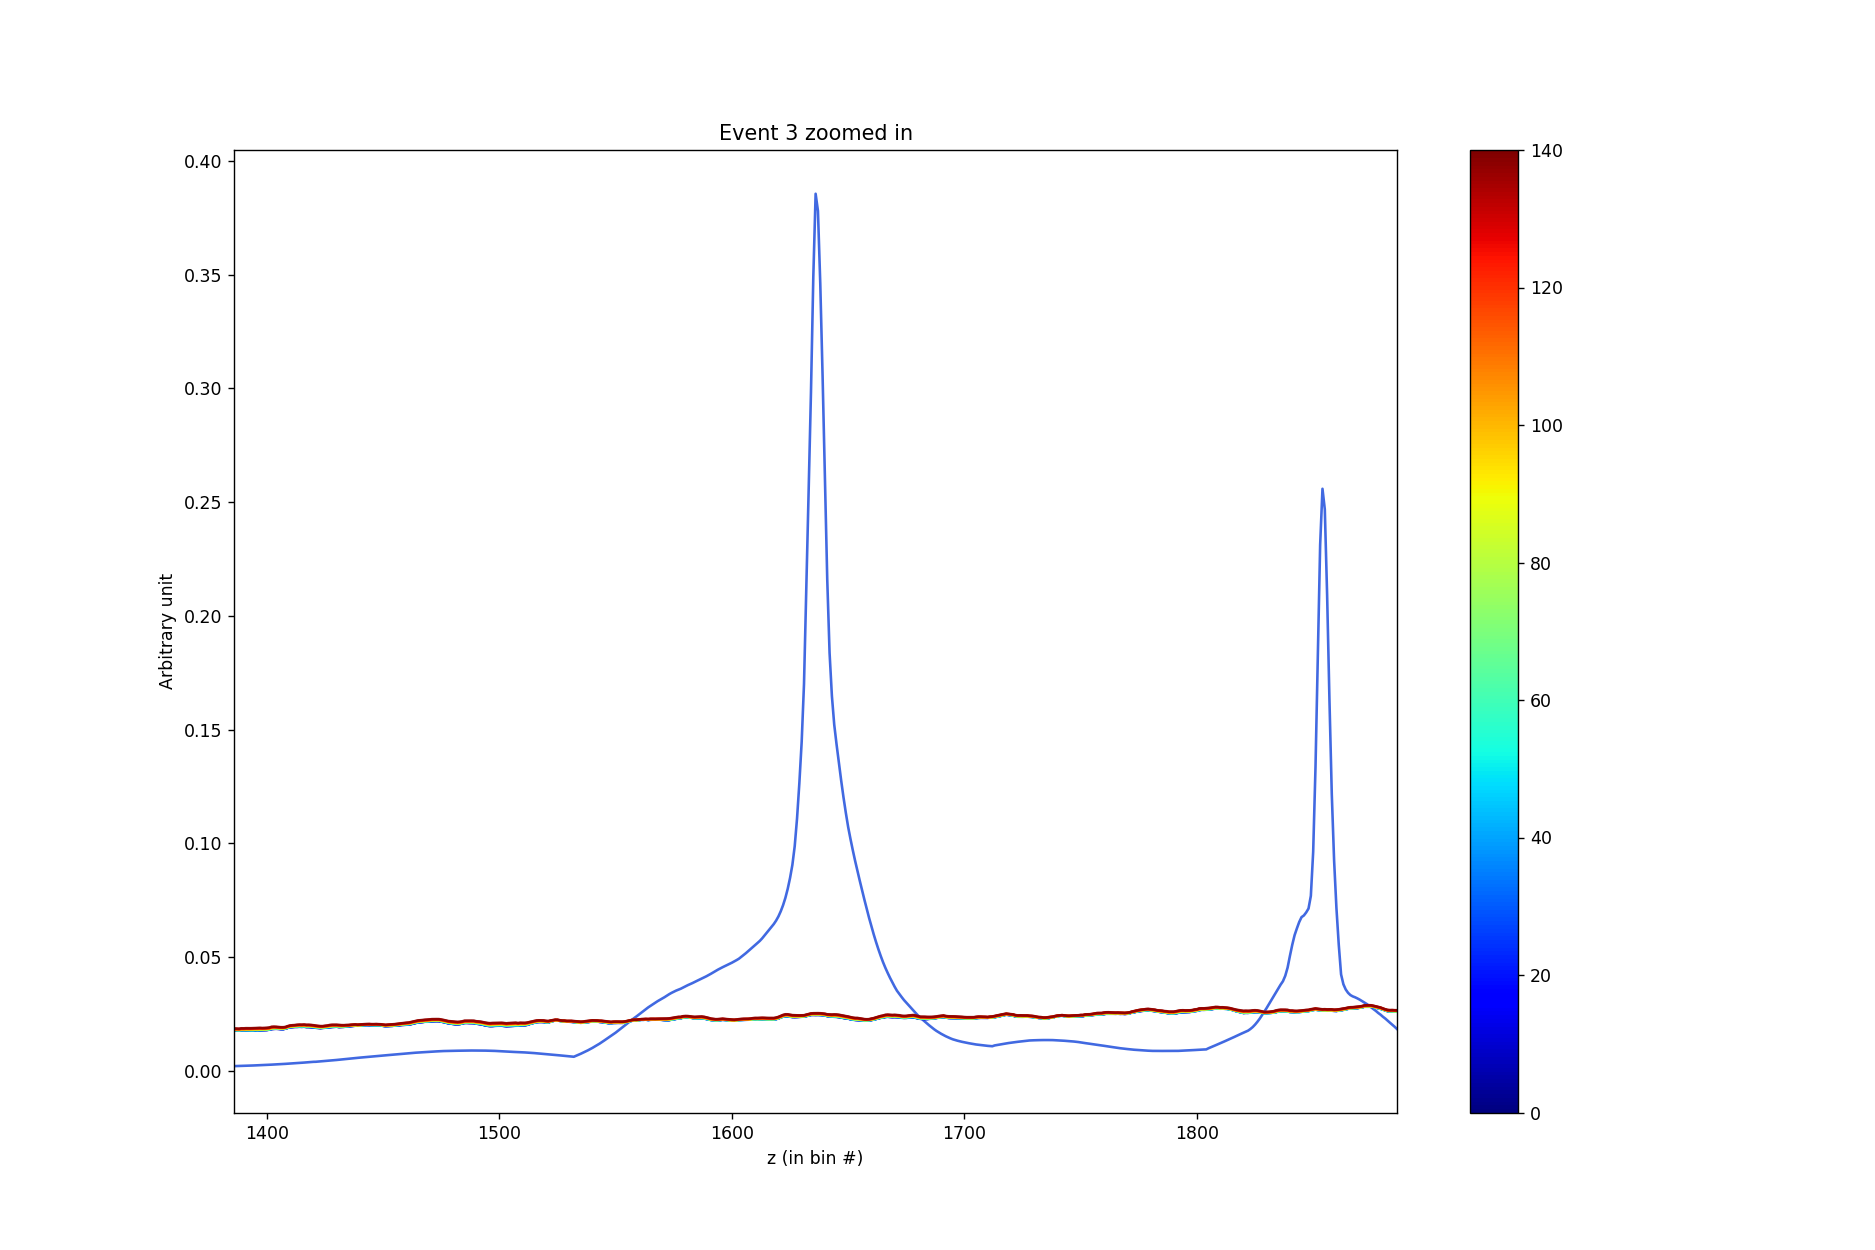

<IPython.core.display.Javascript object>


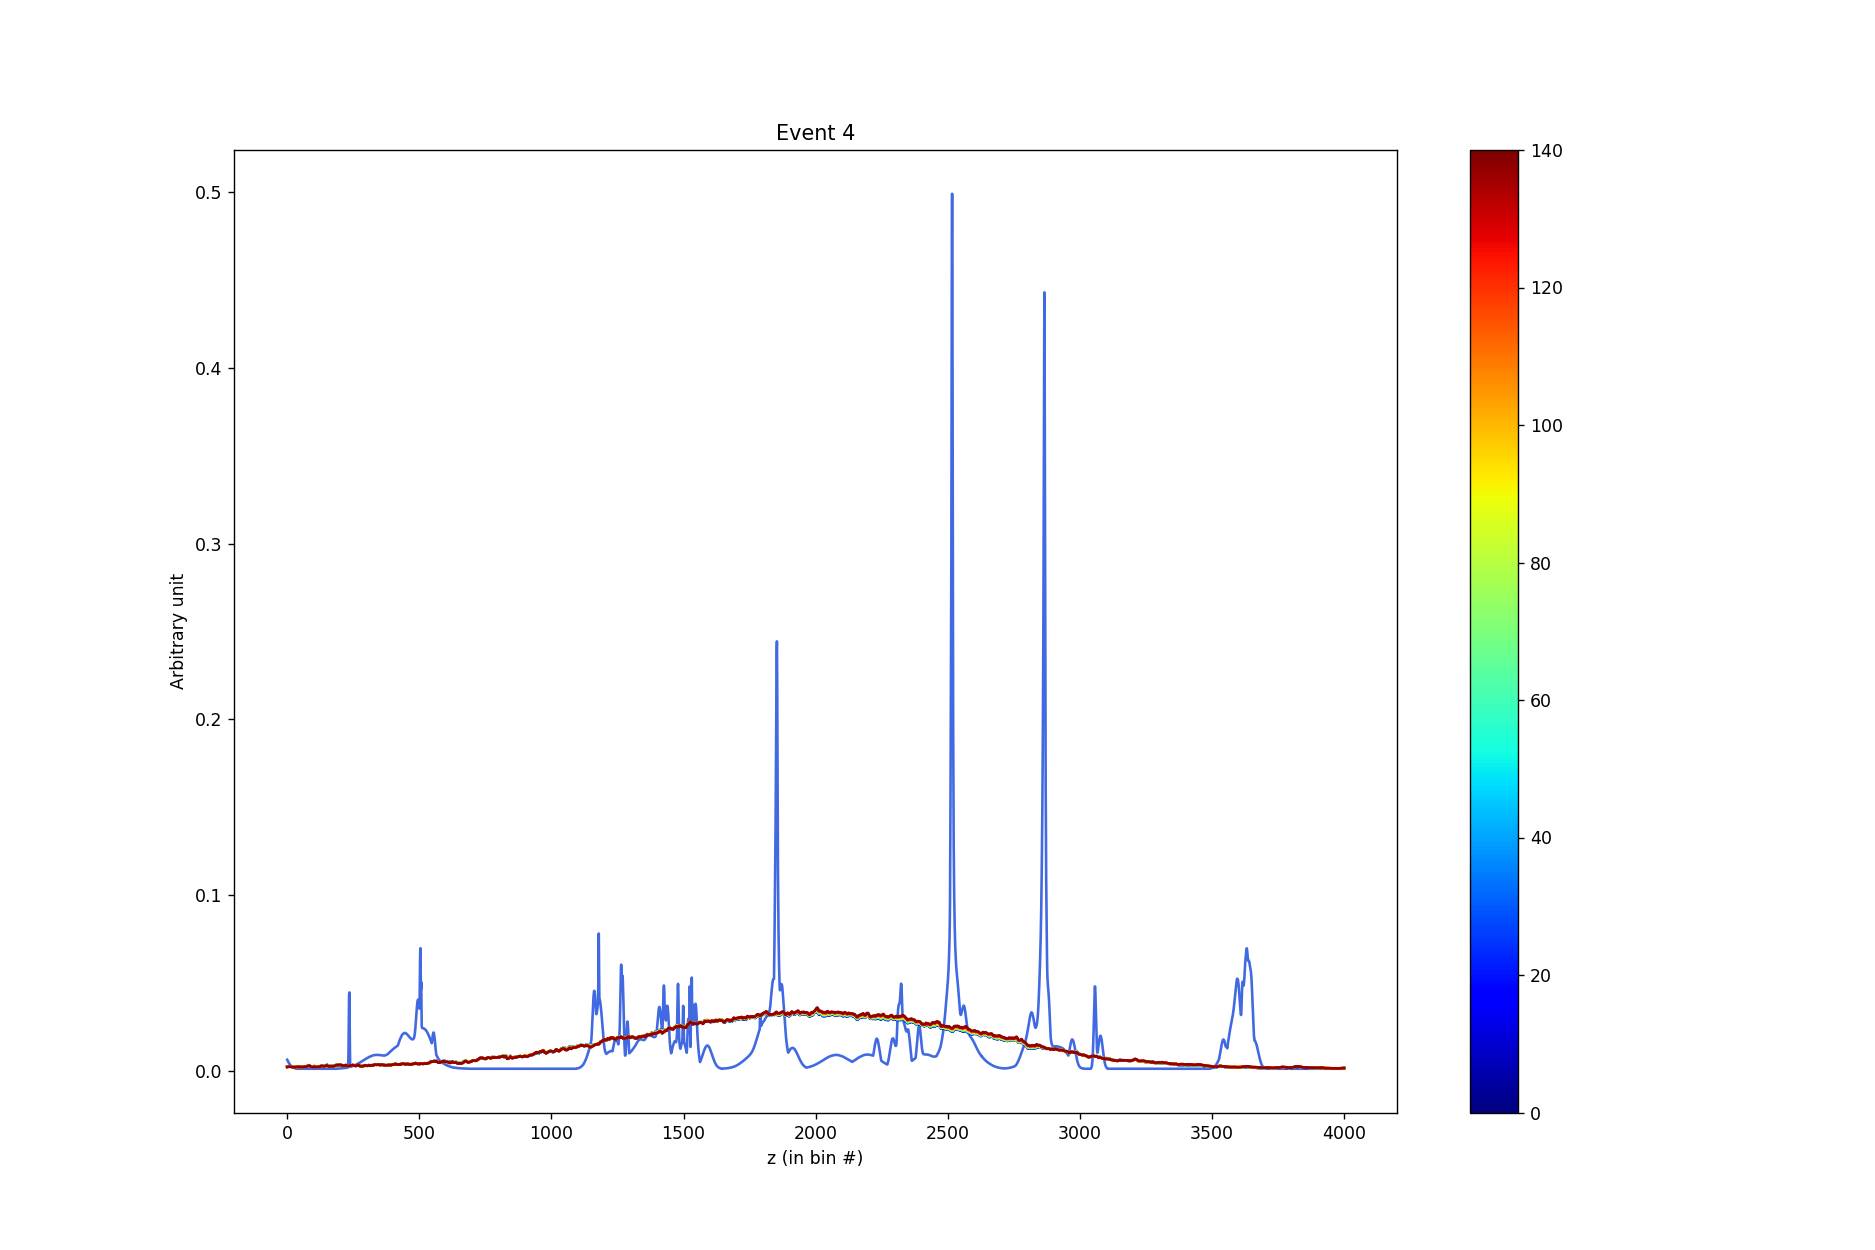

<IPython.core.display.Javascript object>


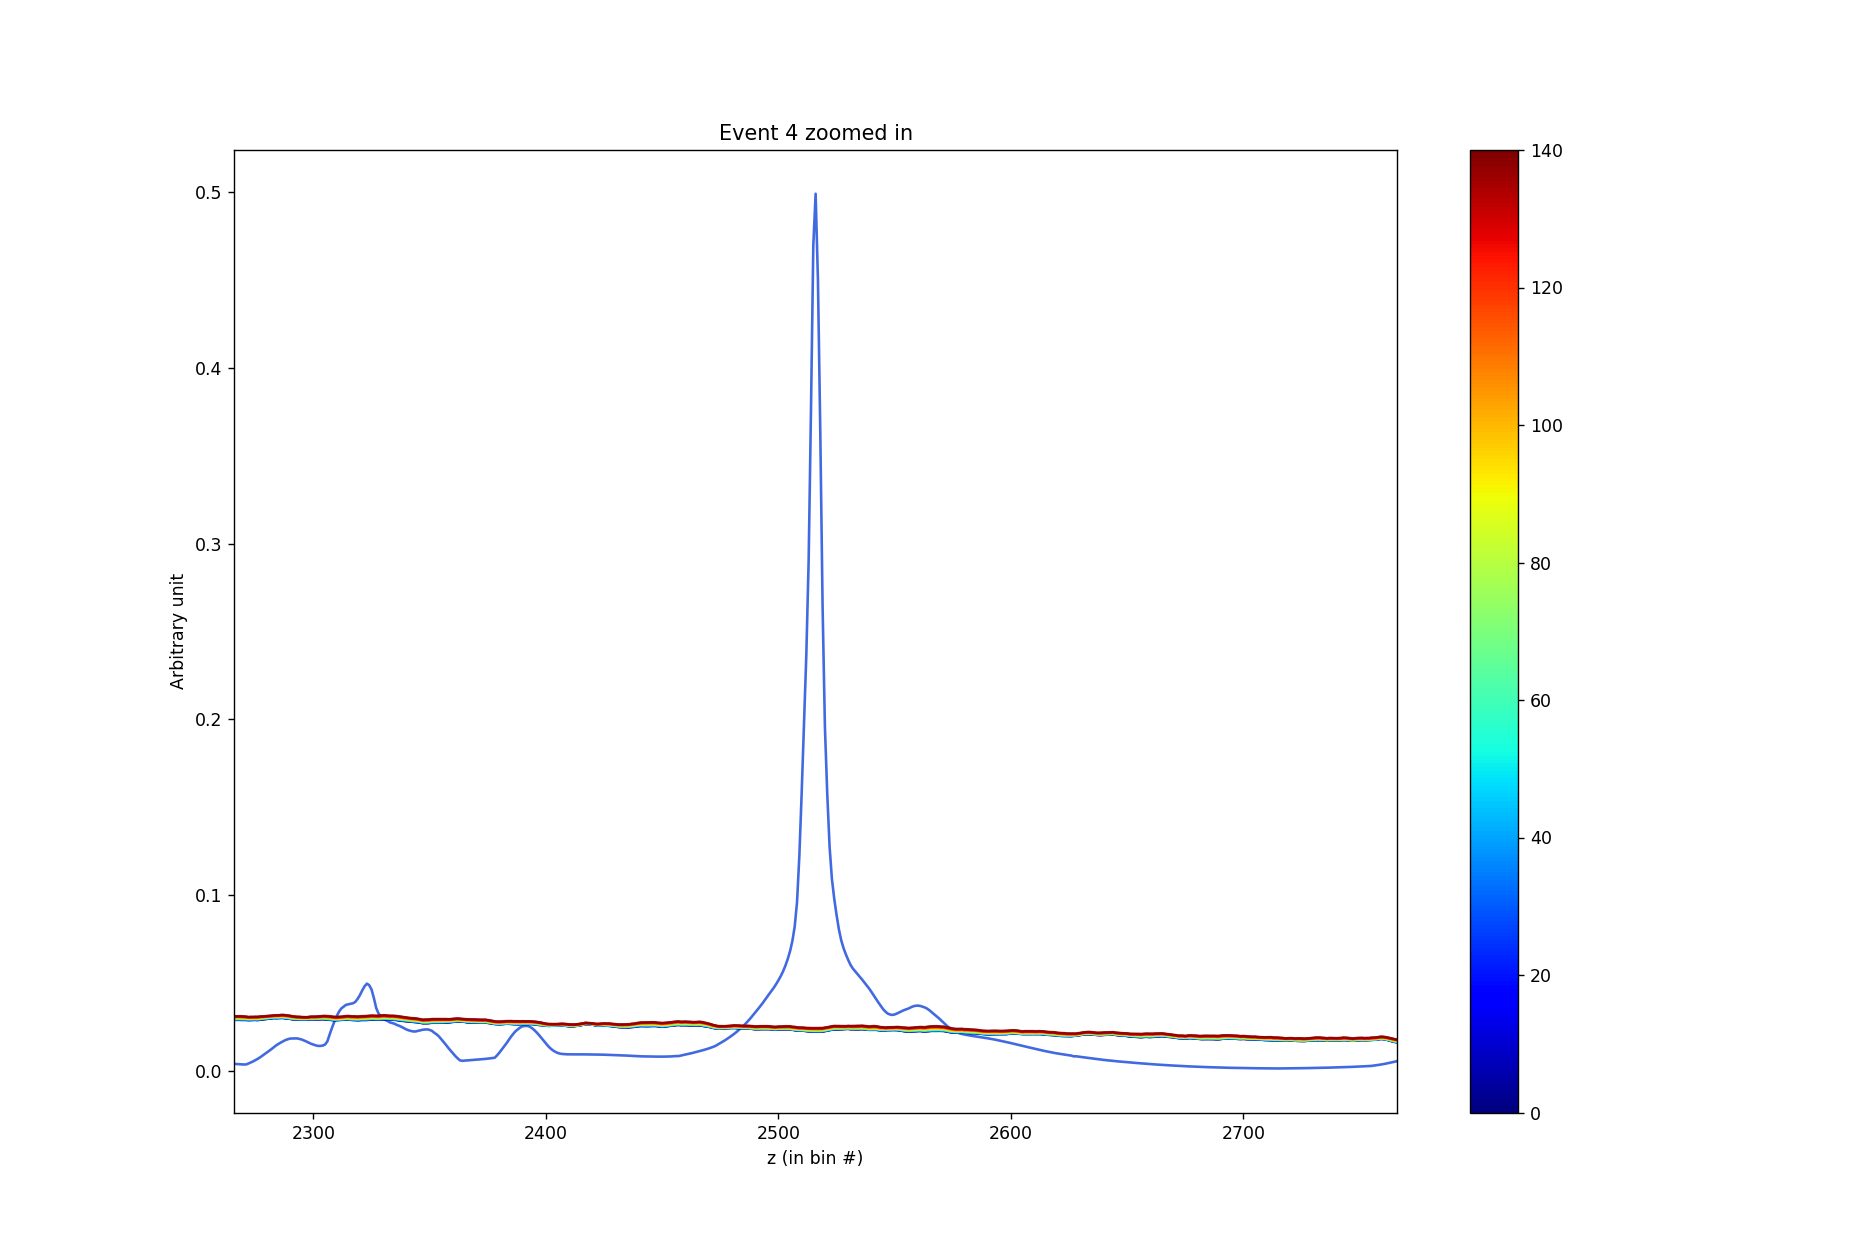

In [24]:
from functions.plotting_DDplus_hists import plot_DDplus_hists as Plot
Plot(state_dicts, data)